# Содержание

1. **Подготовка**
   - 1.1 Подготовка данных (EDA)
   - 1.2 Подготовка к обучению

2. **Обучение моделей**
   - 2.1 LinearRegression
   - 2.2 LightGBM
   - 2.3 Random Forest
   - 2.4 CatBoost

3. **Анализ моделей**

4. **Вывод**



## 1. Подготовка

### 1.1 Подготовка данных (EDA)

In [27]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # Прогресс-бар для циклов
import warnings

# Отключаем предупреждения
warnings.filterwarnings('ignore')

# Метрики и предобработка данных
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder

# Линейные модели
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# Сложные модели
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# Табличное отображение
from tabulate import tabulate

# Таймер
import time


In [28]:
df = pd.read_csv('../data/data.csv')

In [29]:
def check(df):

    print(df.head())
    
    print("\n" + "=" * 50)
    print("Информация о таблице:")
    print(df.info())
    
    print("\n" + "=" * 50)
    print("Описание данных (числовые столбцы):")
    print(tabulate(df.describe().T, headers="keys", tablefmt="grid"))
    
    print("\n" + "=" * 50)
    print("Процент пропусков в каждом столбце:")
    na_data = pd.DataFrame(
        round((df.isna().mean() * 100), 2),
        columns=['NaNs, %']
    ).sort_values(by='NaNs, %', ascending=False)
    print(tabulate(na_data, headers="keys", tablefmt="grid"))
    
    print("\n" + "=" * 50)
    print("Количество дупликатов в таблице:")
    print(f"{df.duplicated().sum()} дубликатов")
    
    print("\n" + "=" * 50)

In [30]:
len1 = len(df)

In [31]:
check(df)

                                             url_car car_make     car_model  \
0  https://auto.ru/cars/used/sale/uaz/3151/112181...      УАЗ          3151   
1  https://auto.ru/cars/used/sale/peugeot/308/112...  Peugeot           308   
2  https://auto.ru/cars/used/sale/kaiyi/e5/112181...    Kaiyi            E5   
3  https://auto.ru/cars/used/sale/gaz/m_20/112181...      ГАЗ  М-20«Победа»   
4  https://auto.ru/cars/used/sale/exeed/vx/112181...    EXEED            VX   

       car_gen         car_type              car_compl    ann_date  \
0    1985-2013  Внедорожник5дв.  315192.9MT(84л.с.)4WD  2024-01-01   
1  IРестайлинг      Хэтчбек5дв.         1.6AT(120л.с.)  2024-01-01   
2    2021-н.в.            Седан        1.5CVT(147л.с.)  2024-01-01   
3    1946-1958          Фастбек          2.1MT(52л.с.)  2024-01-01   
4            I  Внедорожник5дв.     2.0AMT(249л.с.)4WD  2024-01-01   

       ann_id  car_price ann_city  \
0  1121811096     500000    Чехов   
1  1121810455     550000   Мос

In [32]:
# Удаляем ненужный столбец Unnamed: 0, убераем ";" из cyl_count, а также удаляем лишние символы  из cyl_count.
df.drop("Unnamed: 0" , axis='columns', inplace=True, errors='ignore')
df = df.rename(columns={'cyl_count;': 'cyl_count'})


In [33]:

# Делаем отображения всех столбцов DataFrame
pd.set_option('display.max_columns', None)


In [34]:
# Анализ пропусков
na_summary = df.isnull().sum().sort_values(ascending=False)
print(na_summary[na_summary > 0])
# Анализ дубликатов
duplicate_summary = df.duplicated().sum()

print(na_summary[na_summary > 0], duplicate_summary)

Series([], dtype: int64)
Series([], dtype: int64) 0


In [35]:
# Удаление дубликатов
df = df.drop_duplicates()

# Удаление столбцов с более чем 90% пропусков
columns_to_drop = df.columns[df.isnull().mean() > 0.9]
df = df.drop(columns=columns_to_drop)
check(df)

                                             url_car car_make     car_model  \
0  https://auto.ru/cars/used/sale/uaz/3151/112181...      УАЗ          3151   
1  https://auto.ru/cars/used/sale/peugeot/308/112...  Peugeot           308   
2  https://auto.ru/cars/used/sale/kaiyi/e5/112181...    Kaiyi            E5   
3  https://auto.ru/cars/used/sale/gaz/m_20/112181...      ГАЗ  М-20«Победа»   
4  https://auto.ru/cars/used/sale/exeed/vx/112181...    EXEED            VX   

       car_gen         car_type              car_compl    ann_date  \
0    1985-2013  Внедорожник5дв.  315192.9MT(84л.с.)4WD  2024-01-01   
1  IРестайлинг      Хэтчбек5дв.         1.6AT(120л.с.)  2024-01-01   
2    2021-н.в.            Седан        1.5CVT(147л.с.)  2024-01-01   
3    1946-1958          Фастбек          2.1MT(52л.с.)  2024-01-01   
4            I  Внедорожник5дв.     2.0AMT(249л.с.)4WD  2024-01-01   

       ann_id  car_price ann_city  \
0  1121811096     500000    Чехов   
1  1121810455     550000   Мос

In [36]:
# Вывод одинаковых 'ann_id' с количеством повторений
duplicated_ids_count = df['ann_id'].value_counts()

# Вывод результатов
print("Количество повторений для каждого 'ann_id':")
print(duplicated_ids_count.head(10))  # Топ-10 самых частых повторений

# Уникальные ID, которые повторяются
repeated_ids = duplicated_ids_count.index
print("\nПримеры одинаковых 'ann_id':")
print(repeated_ids[:10])  # Топ-10 повторяющихся ID





Количество повторений для каждого 'ann_id':
ann_id
1125480160    2
1125444984    2
1125825446    2
1124248951    2
1125817245    2
1116300292    2
1124261117    2
1125327786    2
1124261293    2
1125940789    2
Name: count, dtype: int64

Примеры одинаковых 'ann_id':
Index([1125480160, 1125444984, 1125825446, 1124248951, 1125817245, 1116300292,
       1124261117, 1125327786, 1124261293, 1125940789],
      dtype='int64', name='ann_id')


In [37]:
# Вывод детальной информации для всех записей с дублирующимися 'ann_id'
example_id = duplicated_ids_count.index[0]
details_for_id = df[df['ann_id'] == example_id]

# Вывод результатов
print(f"Детальная информация для 'ann_id' = {example_id}:")
print(details_for_id)

# Удаление дубликатов по 'ann_id', оставляя последнюю запись по дате
df = df.drop_duplicates()
df = df.sort_values(by='ann_date')
df = df.drop_duplicates(subset='ann_id', keep='last')

# Проверка результата
print(f"Количество строк до очистки: {len(df)}")
print(f"Количество строк после удаления полных дубликатов: {len(df)}")
print(f"Количество строк после удаления дублей 'ann_id': {len(df)}")




Детальная информация для 'ann_id' = 1125480160:
                                                  url_car   car_make  \
44975   https://auto.ru/cars/used/sale/ssang_yong/kyro...  SsangYong   
109177  https://auto.ru/cars/used/sale/ssang_yong/kyro...  SsangYong   

       car_model      car_gen         car_type                 car_compl  \
44975      Kyron  IРестайлинг  Внедорожник5дв.  6-speed2.3AT(150л.с.)4WD   
109177     Kyron  IРестайлинг  Внедорожник5дв.  6-speed2.3AT(150л.с.)4WD   

          ann_date      ann_id  car_price        ann_city  \
44975   2024-10-15  1125480160    1010000  Ростов-на-Дону   
109177  2024-10-15  1125480160    1030000  Ростов-на-Дону   

                                                 link_cpl     avail  year  \
44975   https://auto.ru/catalog/cars/ssang_yong/kyron/...  Вналичии  2010   
109177  https://auto.ru/catalog/cars/ssang_yong/kyron/...  Вналичии  2010   

             mileage   color  eng_size  eng_power eng_type  options  \
44975   2.700000e+0

Повторная очистка данных с корректировками, преобразование единиц измерения и даты 

In [38]:

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '.').str.replace(' ', '').str.strip()


try:
    for col in ['car_price', 'year', 'mileage', 'eng_size', 'eng_power', 'door_count',
                'seat_count', 'long', 'widht', 'height', 'clearence', 'v_bag', 'v_tank',
                'curb_weight', 'gross_weight', 'max_speed', 'acceleration', 'fuel_cons', 
                'max_torq', 'cyl_count']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
except ValueError as e:
    print('{col}: {e}')


df['mileage'] = df['mileage'] / 1000
df['long'] = df['long'] / 1000
df['widht'] = df['widht'] / 1000
df['height'] = df['height'] / 1000 
df['curb_weight'] = df['curb_weight'] / 1000
df['gross_weight'] = df['gross_weight'] / 1000
df['clearence'] = df['clearence'] / 10


df['ann_date'] = pd.to_datetime(df['ann_date'], errors='coerce')

In [39]:
df.head()

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,turbocharg,max_torq,cyl_count
0,https://auto.ru/cars/used/sale/uaz/3151/112181...,УАЗ,3151,1985-2013,Внедорожник5дв.,315192.9MT(84л.с.)4WD,2024-01-01,1121811096,500000,Чехов,https://auto.ru/catalog/cars/uaz/3151/7869981/...,Вналичии,2005,0.12500,серебристый,2.9,84,Бензин,2опции,механическая,полный,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/uaz/3151/7869981/...,Россия,J,5,7.0,0.004025,0.001785,0.002020,2.20,900.0,78.0,0.001750,0.002500,дисковые,барабанные,120.0,13.23339,16.2,gasoline,нет,189.0,4.0
18,https://auto.ru/cars/used/sale/vaz/2109/112181...,Lada(ВАЗ),2109,1987-2006,Хэтчбек5дв.,1.6MT(81л.с.),2024-01-01,1121810838,650000,Обнинск,https://auto.ru/catalog/cars/vaz/2109/6256996/...,Вналичии,2011,1.00000,синий,1.6,81,Бензин,1опция,механическая,передний,Левый,Нетребуетремонта,2владельца,Оригинал,Растаможен,https://auto.ru/catalog/cars/vaz/2109/6256996/...,Россия,B,5,5.0,0.004006,0.001650,0.001402,1.65,270.0,43.0,0.000945,0.001370,дисковые,барабанные,165.0,14.00000,5.7,gasoline,нет,120.0,4.0
17,https://auto.ru/cars/used/sale/geely/coolray/1...,Geely,Coolray,I,Внедорожник5дв.,1.5AMT(150л.с.),2024-01-01,1121810351,2370000,Иркутск,https://auto.ru/catalog/cars/geely/coolray/218...,Вналичии,2022,0.02998,красный,1.5,150,Бензин,FlagshipSport,роботизированная,передний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/geely/coolray/218...,Китай,B,5,5.0,0.004330,0.001800,0.001609,1.90,330.0,45.0,0.001415,0.001715,дисковые,дисковые,190.0,8.40000,5.4,gasoline,турбонаддув,255.0,3.0
16,https://auto.ru/cars/used/sale/peugeot/3008/11...,Peugeot,3008,I,Внедорожник5дв.,1.6MT(120л.с.),2024-01-01,1121811069,795000,Кропоткин,https://auto.ru/catalog/cars/peugeot/3008/6391...,Вналичии,2013,0.23100,белый,1.6,120,Бензин,Access,механическая,передний,Левый,Нетребуетремонта,2владельца,Оригинал,Растаможен,https://auto.ru/catalog/cars/peugeot/3008/6391...,Франция,C,5,5.0,0.004365,0.001837,0.001639,1.70,432.0,60.0,0.001474,0.002000,дисковые,дисковые,185.0,11.80000,5.6,gasoline,нет,160.0,4.0
15,https://auto.ru/cars/used/sale/land_rover/rang...,LandRover,RangeRover,IIIРестайлинг2,Внедорожник5дв.,Supercharged5.0AT(510л.с.)4WD,2024-01-01,1121810411,1300000,Ульяновск,https://auto.ru/catalog/cars/land_rover/range_...,Вналичии,2011,0.24000,белый,5.0,510,Бензин,Westminster,автоматическая,полный,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/land_rover/range_...,Великобритания,J,5,5.0,0.004972,0.002034,0.001877,2.30,535.0,104.0,0.002590,0.002695,дисковые,дисковые,225.0,6.20000,10.7,gasoline,компрессор,625.0,8.0


Смотрим на столбцы с пропущенными значениями и обрабатываем их для дальнейшего удобства работы с данными

In [40]:
df[df['class_auto'].isnull()]
df['class_auto'].value_counts().reset_index()
df['class_auto'] = df['class_auto'].fillna('V')

Смотрим на отсутствует сведения о ПТС
Наиболее оптимальным видится замена нулевых значений на "Дубликат"

In [41]:
df[df['original_pts'].isnull()].head(10)

df['original_pts'] = df['original_pts'].fillna('Дубликат')

df['original_pts'].isnull().sum()

0

Заменим нулевые значения на средние по типу кузова автомобиля

In [42]:
df[df['clearence'].isnull()].head(10)
missing_clearence = df[df['clearence'].isnull()].head(10)

df['clearence'] = df['clearence'].fillna(df.groupby('class_auto')['clearence'].transform('mean'))

print(df['clearence'].isnull().sum())

0


Смотрим на строки без объема багажника. Заполнение пропусков в 'v_bag' значением 0

In [43]:
df[df['v_bag'].isnull()]
df['v_bag'] = df['v_bag'].fillna(0)

print(df['v_bag'].isnull().sum())

0


Смотрим на строки без объема бака. Заполняем пропуски в 'v_tank' значением 0 


In [44]:
df[df['v_tank'].isnull()].head(10)
df['v_tank'] = df['v_tank'].fillna(0)

print(df['v_tank'].isnull().sum())

0


Смотрим на строки без снаряженной массы. Меняем значения снаряженной массы на средние по классу автомобиля

In [45]:
df[df['curb_weight'].isnull()].head(10)
df['curb_weight'] = df['curb_weight'].fillna(df.groupby('class_auto')['curb_weight'].transform('mean'))

print(df['curb_weight'].isnull().sum())

0


Смотрим на строки без полной массы. Меняем значения полной массы на средние по классу автомобиля

In [46]:
df[df['gross_weight'].isnull()].head(10)
df['gross_weight'] = df['gross_weight'].fillna(df.groupby('class_auto')['gross_weight'].transform('mean'))

print(df['gross_weight'].isnull().sum())

0


 Смотрим на пропуски в 'rear_brakes' и  заполнение пропусков в 'rear_brakes'по такой логике:
 - если 'front_brakes' == 'дисковые', то 'rear_brakes' = 'дисковые',
 - иначе заполняем модой по 'class_auto'

In [47]:
brakes_class_auto = df.groupby('class_auto')['rear_brakes'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

brakes_class_auto = brakes_class_auto.to_dict()

def fill_rear_brakes(row):
    if pd.isnull(row['rear_brakes']):
        if row['front_brakes'] == 'дисковые':
            return 'дисковые'
        elif row['class_auto'] in brakes_class_auto:
            return brakes_class_auto[row['class_auto']]
    return row['rear_brakes']

df['rear_brakes'] = df.apply(fill_rear_brakes, axis=1)

df['rear_brakes'].isnull().sum()


0

Cмотрим информации о столбцах 'max_speed' и 'acceleration' и заполнение пропусков средними значениями по группам 'class_auto'


In [48]:
df['max_speed'].describe()
df['acceleration'].describe()

df['max_speed'] = df['max_speed'].fillna(df.groupby('class_auto')['max_speed'].transform('mean'))
df['acceleration'] = df['acceleration'].fillna(df.groupby('class_auto')['acceleration'].transform('mean'))

print(df['max_speed'].isnull().sum(), df['acceleration'].isnull().sum())

0 0


Работаем с столбцом 'fuel_cons' 

Заполняем средними значениями по 'eng_type' и 'eng_size'. Для более редких моделей будем использвоать среднее по 'class_auto'.

Также делаем проверку

In [49]:
df['fuel_cons'] = df['fuel_cons'].fillna(df.groupby(['eng_type', 'eng_size'])['fuel_cons'].transform('mean'))
df['fuel_cons'] = df['fuel_cons'].fillna(df.groupby('class_auto')['fuel_cons'].transform('mean'))

print(df['fuel_cons'].isnull().sum())

0


Проверям где нам еще нужно провести корректировку 

Осталось Поработать с этими столбцами:

engine_loc2  
fuel_brand   
engine_loc1 
turbocharg  
cyl_count    
eng_size     
max_torq     
options      


In [50]:
check(df)

                                              url_car   car_make   car_model  \
0   https://auto.ru/cars/used/sale/uaz/3151/112181...        УАЗ        3151   
18  https://auto.ru/cars/used/sale/vaz/2109/112181...  Lada(ВАЗ)        2109   
17  https://auto.ru/cars/used/sale/geely/coolray/1...      Geely     Coolray   
16  https://auto.ru/cars/used/sale/peugeot/3008/11...    Peugeot        3008   
15  https://auto.ru/cars/used/sale/land_rover/rang...  LandRover  RangeRover   

           car_gen         car_type                      car_compl   ann_date  \
0        1985-2013  Внедорожник5дв.          315192.9MT(84л.с.)4WD 2024-01-01   
18       1987-2006      Хэтчбек5дв.                  1.6MT(81л.с.) 2024-01-01   
17               I  Внедорожник5дв.                1.5AMT(150л.с.) 2024-01-01   
16               I  Внедорожник5дв.                 1.6MT(120л.с.) 2024-01-01   
15  IIIРестайлинг2  Внедорожник5дв.  Supercharged5.0AT(510л.с.)4WD 2024-01-01   

        ann_id  car_price   ann_

Заполнение числовых столбцов средними значениями по 'class_auto'

In [51]:
columns_to_fill_mean_extended = ['eng_size', 'max_torq', 'cyl_count']
for col in columns_to_fill_mean_extended:
    df[col] = df[col].fillna(df.groupby(['class_auto',])[col].transform('mean'))

print(df.isnull().sum())

url_car         0
car_make        0
car_model       0
car_gen         0
car_type        0
car_compl       0
ann_date        0
ann_id          0
car_price       0
ann_city        0
link_cpl        0
avail           0
year            0
mileage         0
color           0
eng_size        0
eng_power       0
eng_type        0
options         0
transmission    0
drive           0
st_wheel        0
condition       0
count_owner     0
original_pts    0
customs         0
url_compl       0
state_mark      0
class_auto      0
door_count      0
seat_count      0
long            0
widht           0
height          0
clearence       0
v_bag           0
v_tank          0
curb_weight     0
gross_weight    0
front_brakes    0
rear_brakes     0
max_speed       0
acceleration    0
fuel_cons       0
fuel_brand      0
turbocharg      0
max_torq        0
cyl_count       0
dtype: int64


Данные по расположению и ориентации двигателя разрознены, полагаю отказаться от их использования при построении модели.

In [52]:
df = df.drop(columns=['engine_loc1'], errors='ignore')
df = df.drop(columns=['engine_loc2'], errors='ignore')


Функция для заполнения 'fuel_brand' на основе типа двигателя, марки автомобиля и специальных условий

In [53]:
def fill_fuel_brand(row):
    if pd.isnull(row['fuel_brand']) or row['fuel_brand'] == 'unknown':
        if row['eng_type'] == 'Бензиновый':
            return 'АИ-95'
        elif row['eng_type'] == 'Дизельный':
            return 'ДТ'
        elif row['eng_type'] == 'Электрический':
            return 'Electro'
        elif row['car_make'] == 'Trabant':
            return 'АИ-80' 
        else:
            return 'unknown'  
    return row['fuel_brand']

df['fuel_brand'] = df.apply(fill_fuel_brand, axis=1)

# Проверка 
print(df['fuel_brand'].isnull().sum())

0


In [54]:
fuel_mapping = {
    'unknown': 'unknown',
    'АИ-95': 'gasoline',
    'АИ-92': 'gasoline',
    'АИ-98': 'gasoline',
    'АИ-80': 'gasoline',
    'АИ-76': 'gasoline',
    'ДТ': 'diesel',
    'Газ(Бензин)': 'gas',
}

df['fuel_brand'] = df['fuel_brand'].map(fuel_mapping)


df['fuel_brand'].isna().sum()

94913

In [55]:
df['eng_type'].unique()

df['eng_type'] = df['eng_type'].replace({
    'Бензин.газобаллонноеоборудование': 'Бензин',
    'Газ.газобаллонноеоборудование': 'Газ',
    'Дизель.газобаллонноеоборудование': 'Дизель'})

print(df['eng_type'].unique())


['Бензин' 'Дизель' 'Электро' 'Гибрид' 'Газ'
 'Гибрид.газобаллонноеоборудование']


In [56]:
print(df['fuel_brand'].unique())

[nan 'gasoline' 'unknown' 'diesel']


In [57]:
df[df['turbocharg'].isnull()].head()
df['turbocharg'].value_counts().reset_index()
df['turbocharg'] = df['turbocharg'].fillna('нет')

print(df['turbocharg'].isnull().sum())

0


In [58]:
df.loc[(df['fuel_brand'] == 'unknown') & (df['car_compl'].str.contains('Electro', na=False)), 'fuel_brand'] = 'Electro'
df.loc[df['fuel_brand'] == 'Electro', 'fuel_cons'] = 0

updated_fuel_brand_counts = df['fuel_brand'].value_counts()
updated_fuel_cons_summary = df[df['fuel_brand'] == 'Electro']['fuel_cons'].describe()

updated_fuel_brand_counts, updated_fuel_cons_summary


(fuel_brand
 gasoline    11090
 diesel       1421
 unknown       463
 Electro       220
 Name: count, dtype: int64,
 count    220.0
 mean       0.0
 std        0.0
 min        0.0
 25%        0.0
 50%        0.0
 75%        0.0
 max        0.0
 Name: fuel_cons, dtype: float64)

Заполнение пропусков в 'options' модой по группам 'class_auto'

In [59]:
df['options'] = df['options'].fillna(df.groupby('class_auto')['options'].transform('first'))

print(df['options'].isnull().sum())

0



Очищаем данные в seat_count, заполняет пропуски медианой по class_auto, затем средним значением

In [60]:
df['seat_count'] = df['seat_count'].astype(str).str.replace(',', '.').str.strip()
df['seat_count'] = pd.to_numeric(df['seat_count'], errors='coerce')


df['seat_count'] = df['seat_count'].fillna(df.groupby('class_auto')['seat_count'].transform('median'))
df['seat_count'] = df['seat_count'].fillna(df['seat_count'].mean())

print(df['seat_count'].isnull().sum())


0


In [61]:
check(df)

                                              url_car   car_make   car_model  \
0   https://auto.ru/cars/used/sale/uaz/3151/112181...        УАЗ        3151   
18  https://auto.ru/cars/used/sale/vaz/2109/112181...  Lada(ВАЗ)        2109   
17  https://auto.ru/cars/used/sale/geely/coolray/1...      Geely     Coolray   
16  https://auto.ru/cars/used/sale/peugeot/3008/11...    Peugeot        3008   
15  https://auto.ru/cars/used/sale/land_rover/rang...  LandRover  RangeRover   

           car_gen         car_type                      car_compl   ann_date  \
0        1985-2013  Внедорожник5дв.          315192.9MT(84л.с.)4WD 2024-01-01   
18       1987-2006      Хэтчбек5дв.                  1.6MT(81л.с.) 2024-01-01   
17               I  Внедорожник5дв.                1.5AMT(150л.с.) 2024-01-01   
16               I  Внедорожник5дв.                 1.6MT(120л.с.) 2024-01-01   
15  IIIРестайлинг2  Внедорожник5дв.  Supercharged5.0AT(510л.с.)4WD 2024-01-01   

        ann_id  car_price   ann_

0it [00:00, ?it/s]

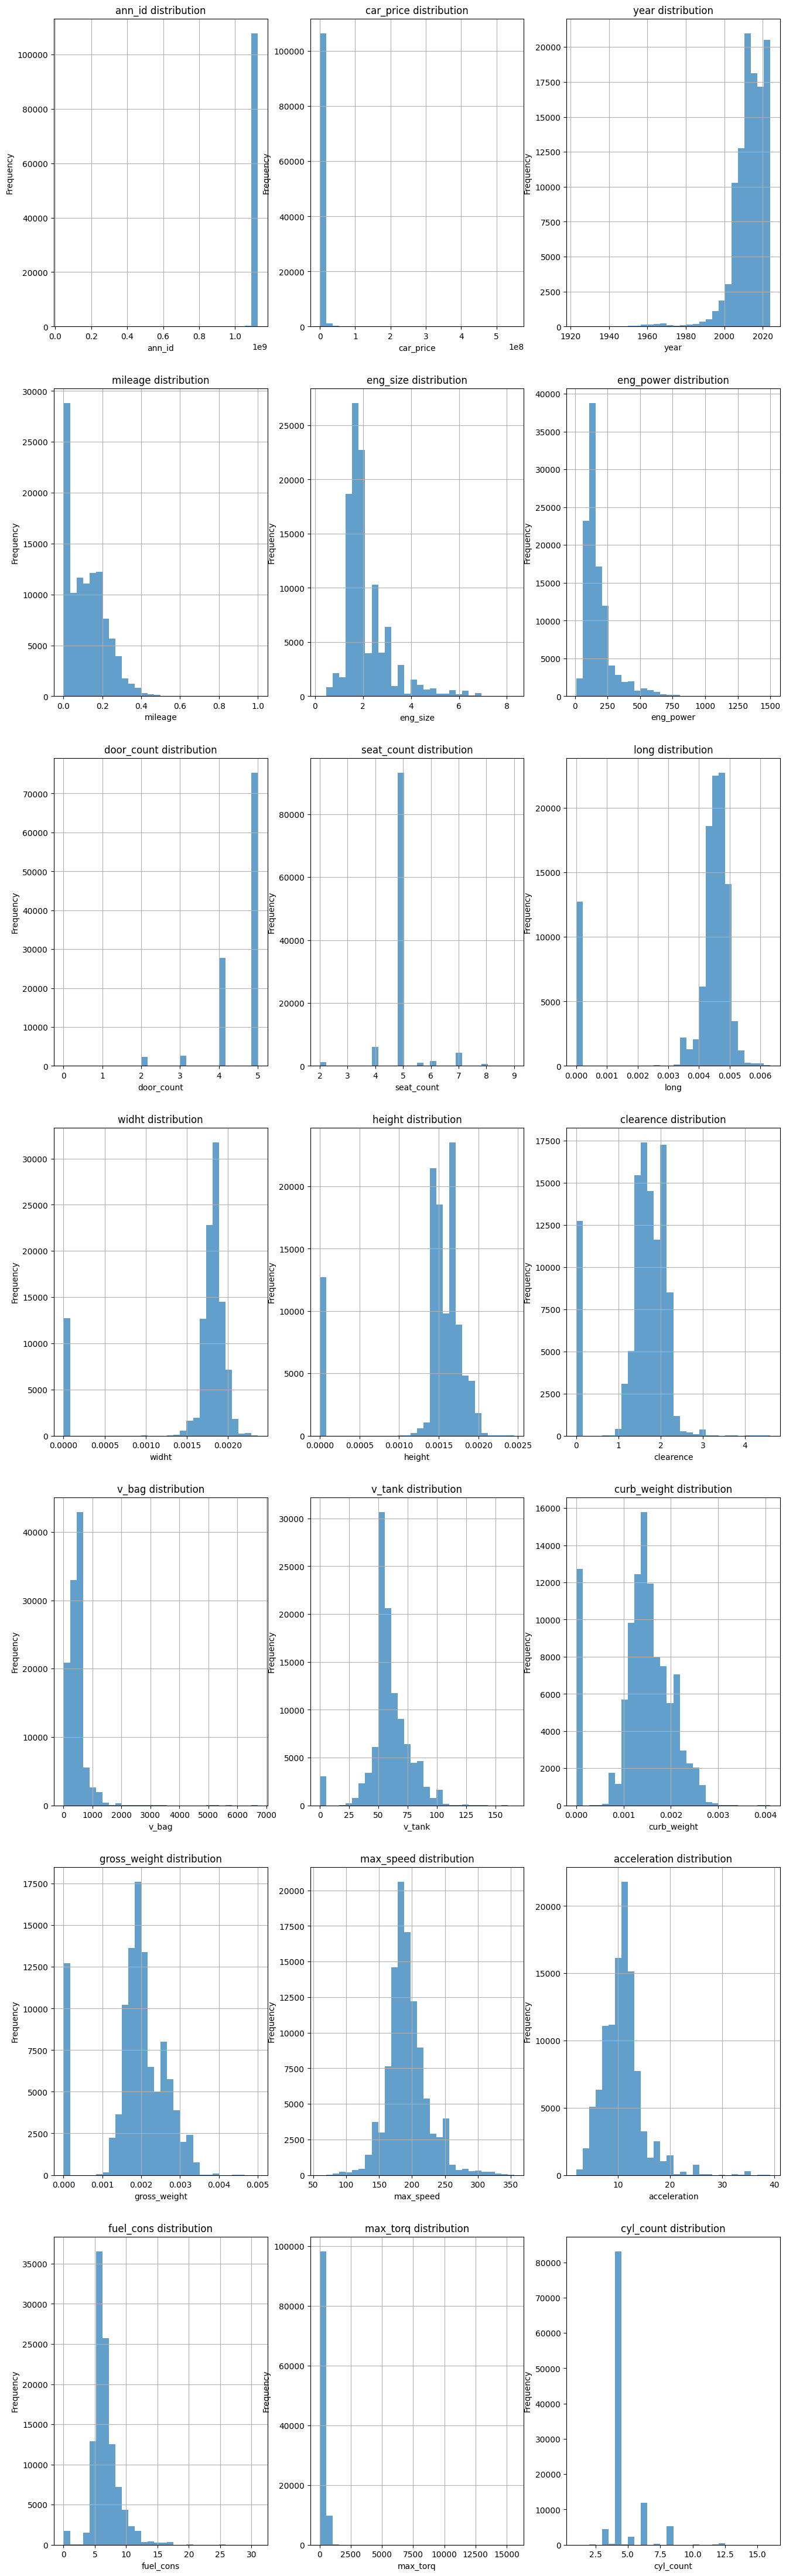

In [62]:
numeric_cols = df.select_dtypes([int, float]).columns
num_cols = len(numeric_cols)
fig, axes = plt.subplots(nrows=(num_cols // 3) + (num_cols % 3), ncols=3, figsize=(16, (num_cols // 3 + 1) * 7))
for ax, col in tqdm(zip(axes.flatten(), numeric_cols)):
    ax.hist(df[col], bins=30, alpha=0.7)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid()

for i in range(num_cols, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.grid()
plt.show()

В данных наблюдается некоторое искажение: для пробега автомобиля преобладают значения близкие к нулю, возможно влиение параллельного импорта. Посмотрим на разброс данных по стране производства автомобиля

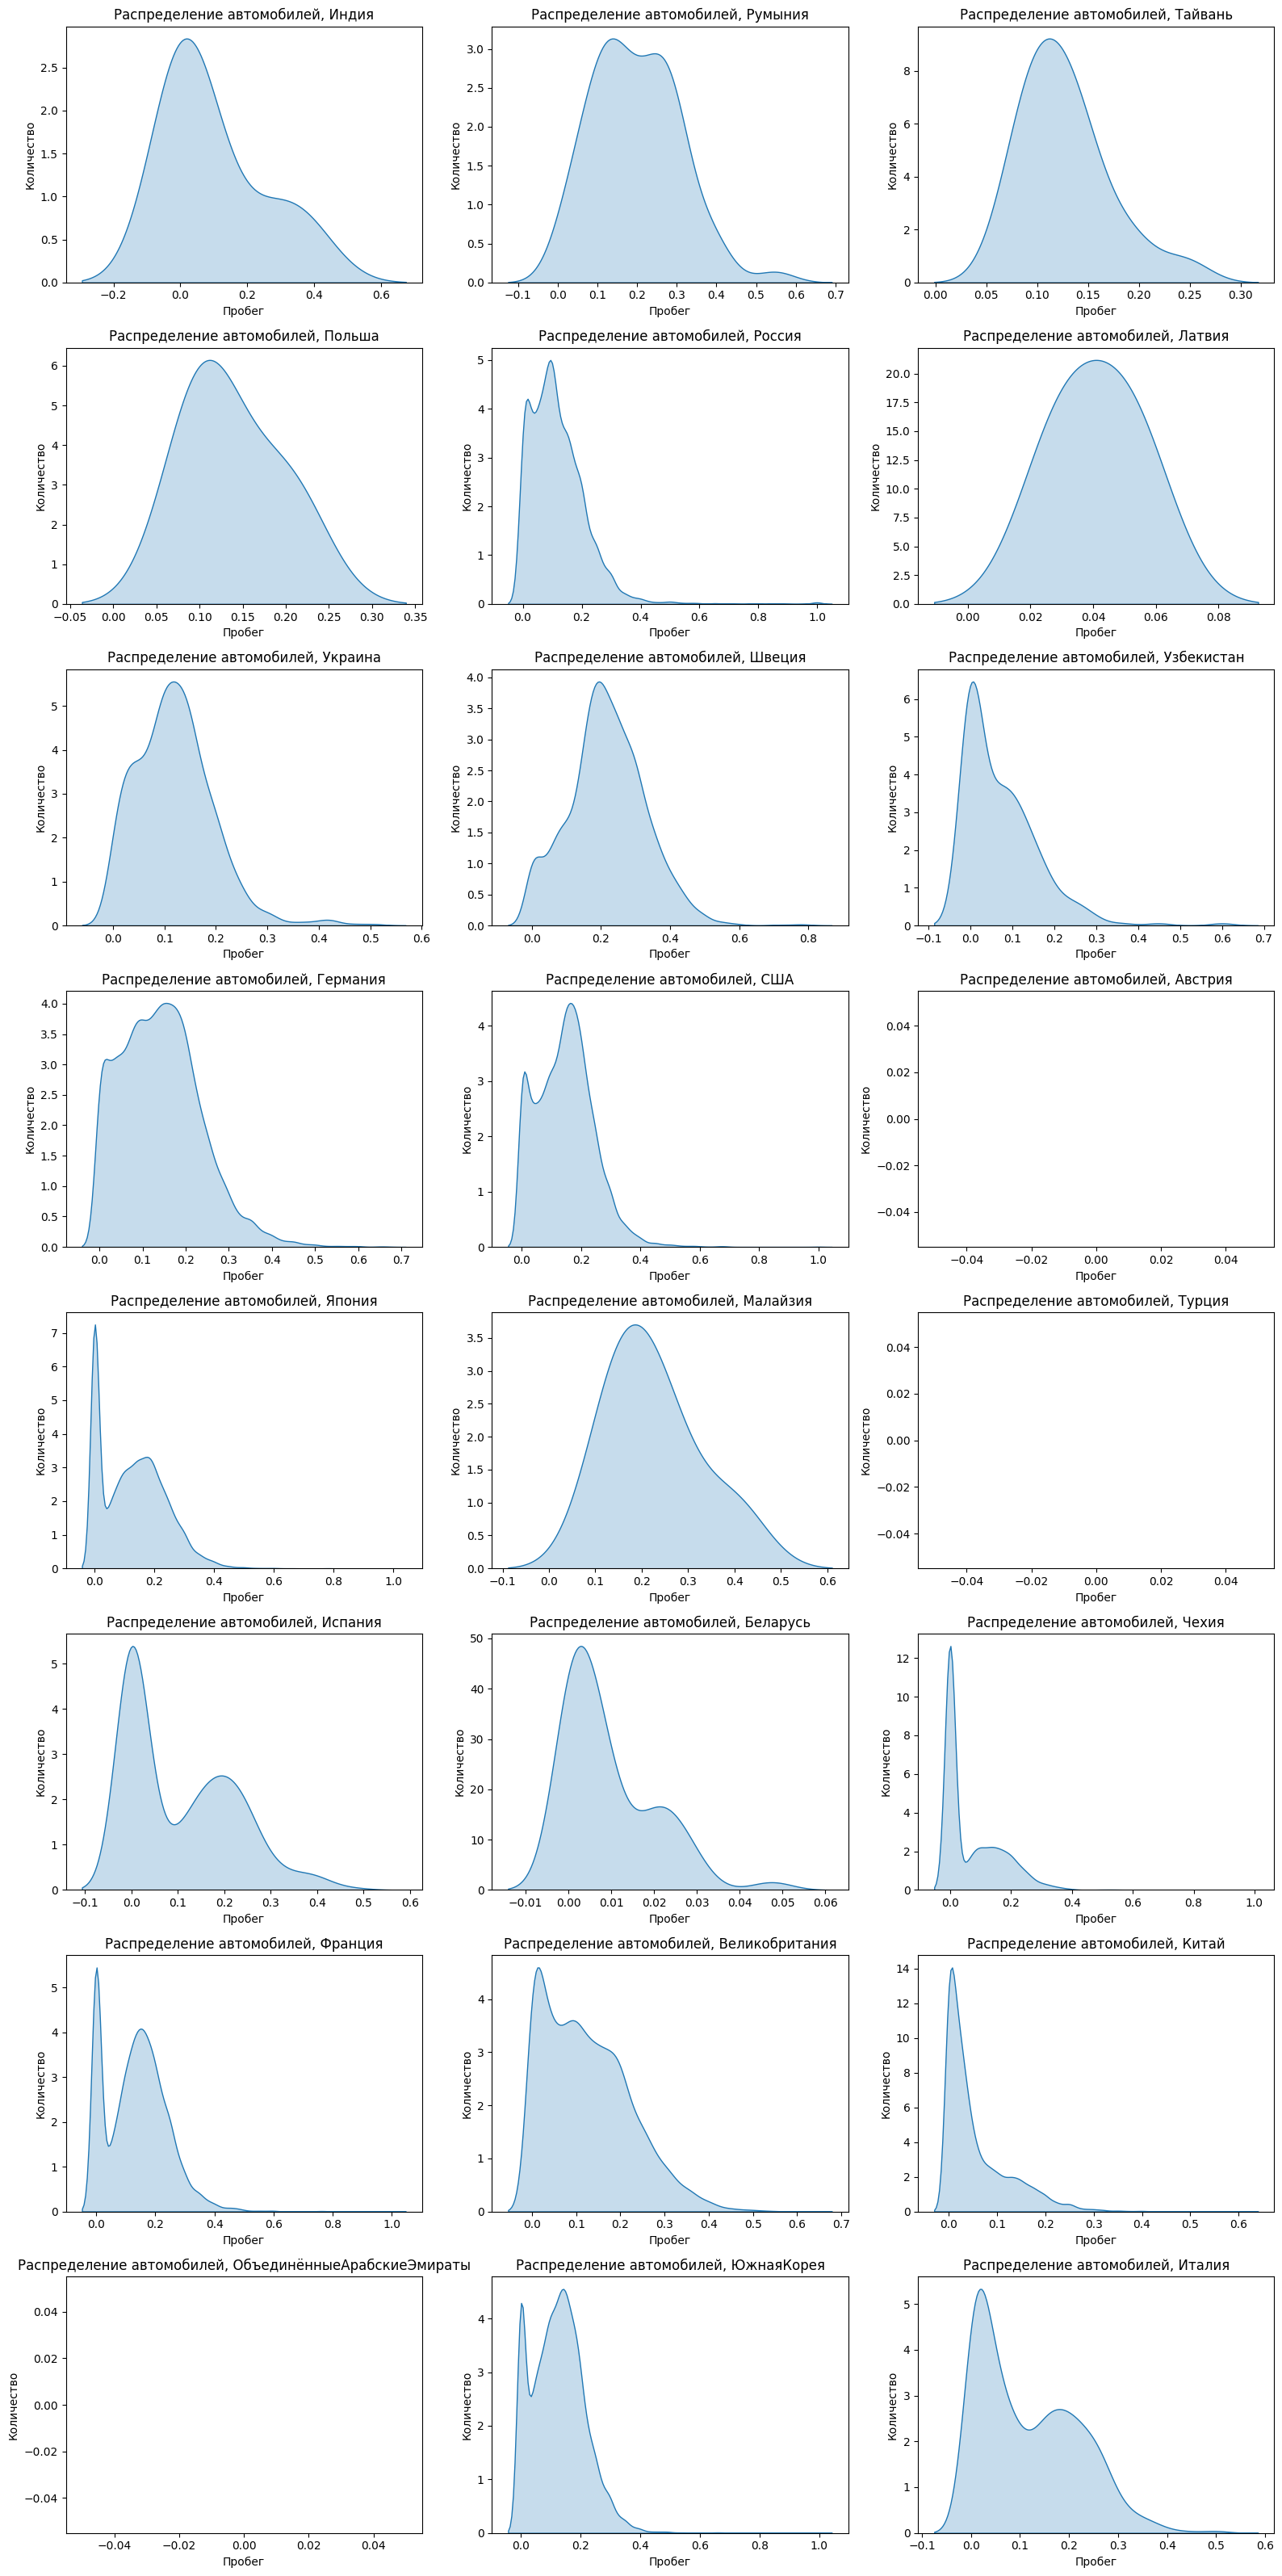

In [63]:
total_axes = len(set(df['state_mark']))
fig = plt.figure(figsize=(16, ((total_axes//3) + (total_axes % 3))*4))
for i, state in enumerate(set(df['state_mark'])):
    ax = fig.add_subplot((total_axes//3) + (total_axes % 3), 3, i+1)
    df_state = df[df['state_mark'] == state]
    sns.kdeplot(df_state['mileage'], fill=True)
    plt.title(f'Распределение автомобилей, {state}')
    plt.xlabel('Пробег')
    plt.ylabel('Количество')
plt.tight_layout()
plt.show()

Наблюдаем сильные искажения для Китая, Беларуси - большинство подержанных автомобилей имеют малый пробег. Кроме того, автомобили из Германии и Японии имеют два пика распределения. Для построения модели скорее всего потребуется исключать автомобили с небольшим пробегом

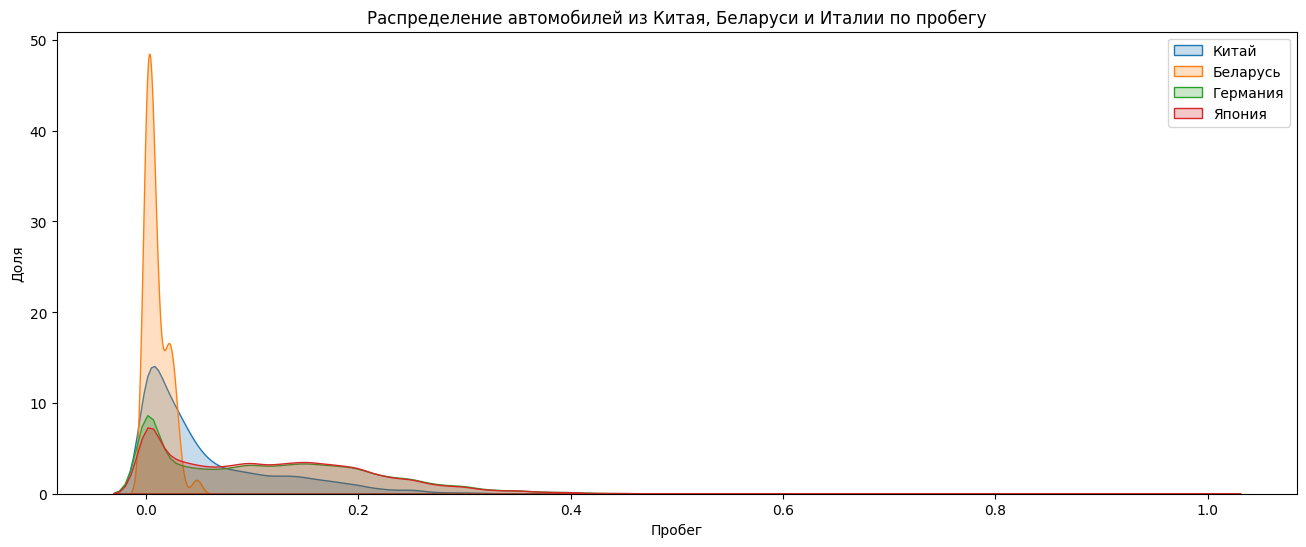

In [64]:
plt.figure(figsize= (16,6))
df_k = df[df['state_mark'] == 'Китай']
df_b = df[df['state_mark'] == 'Беларусь']
df_g = df[df['state_mark'] != 'Германия']
df_j = df[df['state_mark'] != 'Япония']
sns.kdeplot(df_k['mileage'], fill=True, label='Китай')
sns.kdeplot(df_b['mileage'], fill=True, label='Беларусь')
sns.kdeplot(df_g['mileage'], fill=True, label='Германия')
sns.kdeplot(df_j['mileage'], fill=True, label='Япония')
plt.title("Распределение автомобилей из Китая, Беларуси и Италии по пробегу")
plt.xlabel('Пробег')
plt.ylabel('Доля')
plt.legend()
plt.show()

<Axes: >

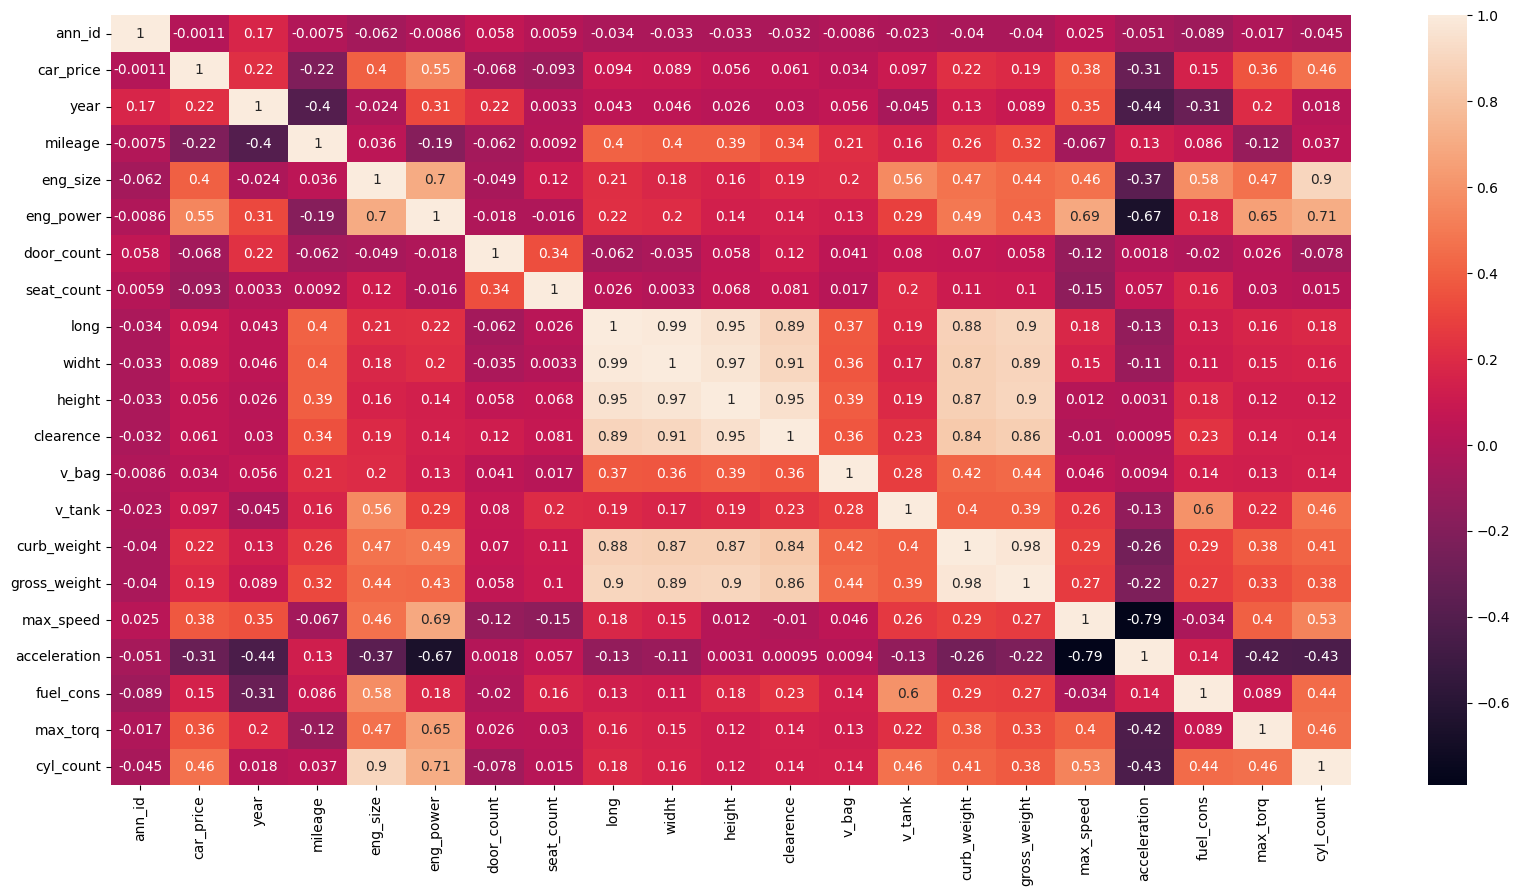

In [65]:
df_corr = df.select_dtypes(['int', 'float'])
plt.figure(figsize= (20,10))
sns.heatmap(df_corr.corr(), annot = True, fmt='.2g')

##### Из анализа нашей тепловой карты (heatmap), можно выделить следующие зависимости цены автомобиля:
1. **Сильные положительные зависимости**:
   - **"max_torq"**: Более высокий крутящий момент связан с мощностью и классом автомобиля, увеличивая его стоимость.
   - **"cyl_count"**: Больше цилиндров — сложнее двигатель, выше цена.
   - **"max_speed"**: Высокая скорость характерна для дорогих спортивных авто.

2. **Слабые или отрицательные зависимости**:
   - **"acceleration"**: Слабая корреляция с ценой, возможно, из-за нелинейных зависимостей.

3. **Взаимозависимые признаки**:
   - **"cyl_count"**, **"max_torq"**: Сильно связаны с ценой через характеристики двигателя.

4. **Потенциальные влияющие признаки**:
   - **"fuel_cons"**: Может слабо коррелировать с ценой, но важен для премиум-класса.



In [66]:

key_columns = df.select_dtypes(include=['number'])

key_columns = [col for col in key_columns if col in df.columns]

key_columns_data = df[key_columns].select_dtypes(include=["number"]) 

outs_key_summary = {}

for column in key_columns_data.columns:

    Q1 = key_columns_data[column].quantile(0.10)
    Q3 = key_columns_data[column].quantile(0.90)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3.5 * IQR
    upper_bound = Q3 + 3.5 * IQR


    outs = key_columns_data[(key_columns_data[column] < lower_bound) | (key_columns_data[column] > upper_bound)]
    outs_count = len(outs)
    outs_key_summary[column] = {
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Outlier Count": outs_count,
        "Percentage Outliers": (outs_count / len(key_columns_data)) * 100,
    }

outs_key_df = pd.DataFrame(outs_key_summary).T

print(outs_key_df)

               Lower Bound   Upper Bound  Outlier Count  Percentage Outliers
ann_id        1.108797e+09  1.139207e+09         1442.0             1.333864
car_price    -1.589000e+07  2.123000e+07         1237.0             1.144237
year          1.945500e+03  2.081500e+03           37.0             0.034225
mileage      -8.750000e-01  1.125000e+00            0.0             0.000000
eng_size     -4.200000e+00  8.600000e+00            0.0             0.000000
eng_power    -6.840000e+02  1.076000e+03           37.0             0.034225
door_count    5.000000e-01  8.500000e+00            2.0             0.001850
seat_count    5.000000e+00  5.000000e+00        14894.0            13.777091
long         -1.730750e-02  2.225250e-02            0.0             0.000000
widht        -6.835500e-03  8.788500e-03            0.0             0.000000
height       -6.300000e-03  8.100000e-03            0.0             0.000000
clearence    -7.445550e+00  9.577650e+00            0.0             0.000000

In [67]:
df[df['year']<1970].head(30)

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,turbocharg,max_torq,cyl_count
3,https://auto.ru/cars/used/sale/gaz/m_20/112181...,ГАЗ,М-20«Победа»,1946-1958,Фастбек,2.1MT(52л.с.),2024-01-01,1121810909,650000,Нальчик,https://auto.ru/catalog/cars/gaz/m_20/20258133...,Вналичии,1954,0.300000,коричневый,2.1,52,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/m_20/20258133...,Россия,D,5,5.0,0.004665,0.001695,0.001640,2.000000,0.0,55.0,0.001460,0.001835,барабанные,барабанные,105.000000,10.072773,17.000000,NaN,нет,127.000000,4.0
5,https://auto.ru/cars/used/sale/gaz/69/10430439...,ГАЗ,69,1953-1972,Внедорожник5дв.69А,69А2.1MT(55л.с.)4WD,2024-01-01,1043043974,150000,Семилуки,https://auto.ru/catalog/cars/gaz/69/20351692/2...,Вналичии,1958,0.030000,зелёный,2.1,55,Бензин,3опции,механическая,полный,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/69/20351692/2...,Россия,J,4,5.0,0.003850,0.001750,0.001930,2.100000,0.0,60.0,0.002066,0.001960,барабанные,барабанные,90.000000,13.233390,17.000000,NaN,нет,150.000000,4.0
30,https://auto.ru/cars/used/sale/gaz/21/11177507...,ГАЗ,21«Волга»,1956-1970,Седан,21Л2.5MT(75л.с.),2024-01-02,1117750723,2500000,Краснодар,https://auto.ru/catalog/cars/gaz/21/7867811/78...,Вналичии,1962,0.000500,серый,2.5,75,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/21/7867811/78...,Россия,D,4,5.0,0.004770,0.001885,0.001620,1.900000,400.0,60.0,0.001460,0.001885,барабанные,барабанные,130.000000,25.000000,11.000000,NaN,нет,170.000000,4.0
54,https://auto.ru/cars/used/sale/gaz/69/11064752...,ГАЗ,69,1953-1972,Внедорожник3дв.,2.1MT(55л.с.)4WD,2024-01-03,1106475252,650000,Рязань,https://auto.ru/catalog/cars/gaz/69/20351692/2...,Вналичии,1964,0.020000,зелёный,2.1,55,Бензин,18опций,механическая,полный,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/69/20351692/2...,Россия,J,2,7.0,0.003850,0.001750,0.001930,2.100000,0.0,75.0,0.002066,0.002175,барабанные,барабанные,90.000000,13.233390,17.000000,NaN,нет,150.000000,4.0
61,https://auto.ru/cars/used/sale/moscvich/400/11...,Москвич,400,1946-1956,Кабриолет,400-4201.1MT(23л.с.),2024-01-03,1121820769,1650000,Санкт-Петербург,https://auto.ru/catalog/cars/moscvich/400/2035...,Вналичии,1950,0.000500,красный,1.1,23,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/moscvich/400/2035...,Россия,C,4,4.0,0.003855,0.001400,0.001555,2.000000,0.0,31.0,0.000885,0.001155,барабанные,барабанные,90.000000,11.022000,5.112871,NaN,нет,55.000000,4.0
57,https://auto.ru/cars/used/sale/gaz/21/10281185...,ГАЗ,21«Волга»,1956-1970,Седан,21Р2.5MT(75л.с.),2024-01-03,1028118509,500000,Санкт-Петербург,https://auto.ru/catalog/cars/gaz/21/7867811/78...,Вналичии,1967,0.150000,синий,2.5,75,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,2владельца,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/21/7867811/78...,Россия,D,4,5.0,0.004770,0.001885,0.001620,1.900000,400.0,60.0,0.001460,0.001885,барабанные,барабанные,130.000000,25.000000,11.000000,NaN,нет,170.000000,4.0
123,https://auto.ru/cars/used/sale/gaz/69/10676554...,ГАЗ,69,1953-1972,Внедорожник3дв.,2.1MT(55л.с.)4WD,2024-01-05,1067655462,950000,Самара,https://auto.ru/catalog/cars/gaz/69/20351692/2...,Вналичии,1969,0.001000,белый,2.1,55,Бензин,7опций,механическая,полный,Левый,Нетребуетремонта,2владельца,Дубликат,Растаможен,https://auto.ru/catalog/cars/gaz/69/20351692/2...,Россия,J,2,7.0,0.003850,0.001750,0.001930,2.100000,0


Для прогнозирования цены автомобиля нужно отобрать признаки с сильной корреляцией с ценой (например, мощность двигателя, количество цилиндров), исключить избыточные признаки (мультиколлинеарность) и обработать категориальные данные. Важно устранить выбросы, масштабировать числовые признаки и протестировать разные модели: от простых (линейная регрессия, дерево решений) до сложных (Random Forest, XGBoost). Методы нелинейного моделирования предпочтительны из-за сложных зависимостей. Для оценки качества модели использовать метрики RMSE, MAE, R² и перекрёстную валидацию. Так как правильная подготовка данных и выбор моделей обеспечат точное прогнозирование.

Столбец: url_car
Уникальные значения:
Столбец: car_make
Уникальные значения:
Столбец: car_model
Уникальные значения:
Столбец: car_gen
Уникальные значения:
Столбец: car_type
Уникальные значения:
Столбец: car_compl
Уникальные значения:
Столбец: ann_date
Уникальные значения:
Столбец: ann_id
Уникальные значения:


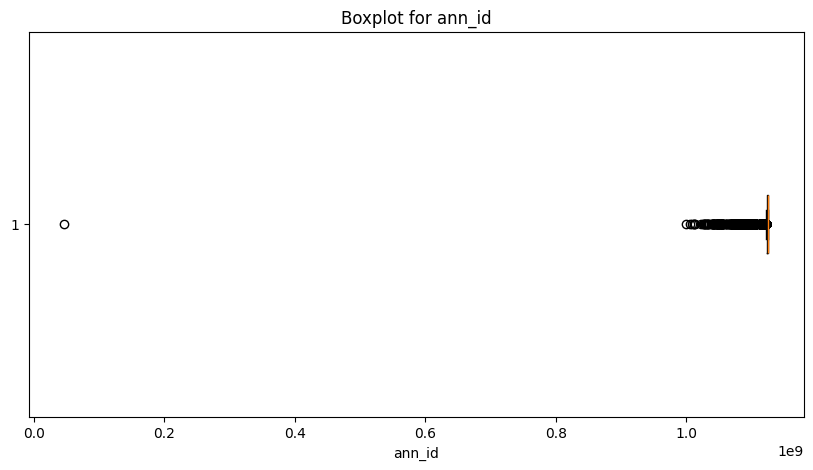

Столбец: car_price
Уникальные значения:


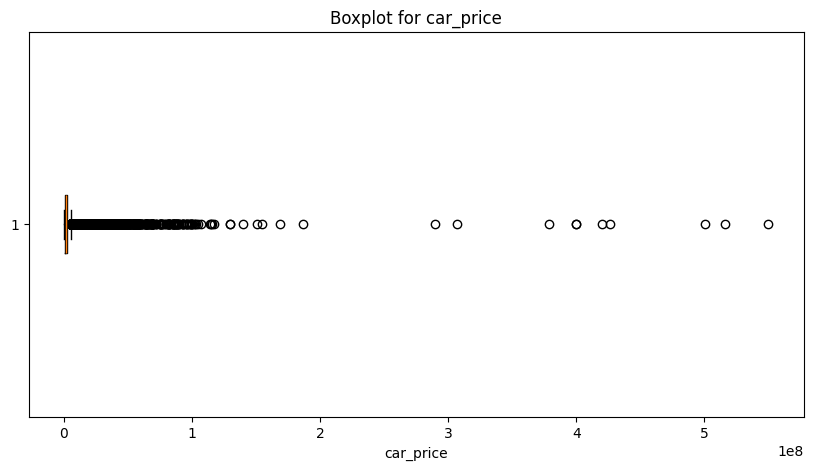

Столбец: ann_city
Уникальные значения:
Столбец: link_cpl
Уникальные значения:
Столбец: avail
Уникальные значения:
Столбец: year
Уникальные значения:


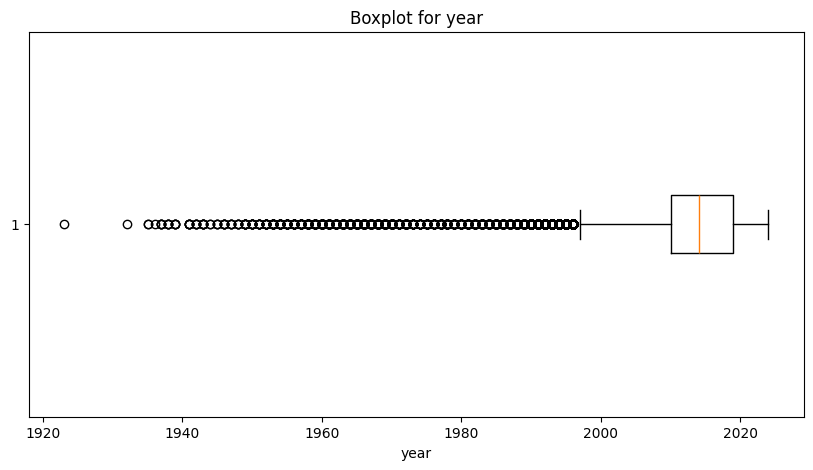

Столбец: mileage
Уникальные значения:


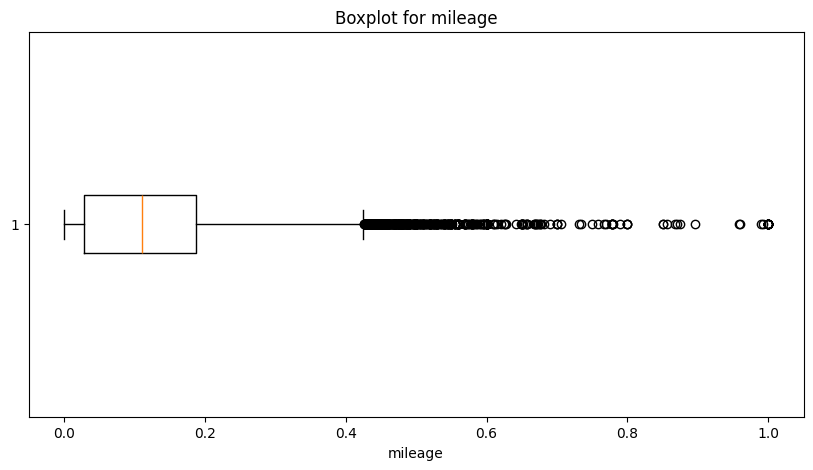

Столбец: color
Уникальные значения:
Столбец: eng_size
Уникальные значения:


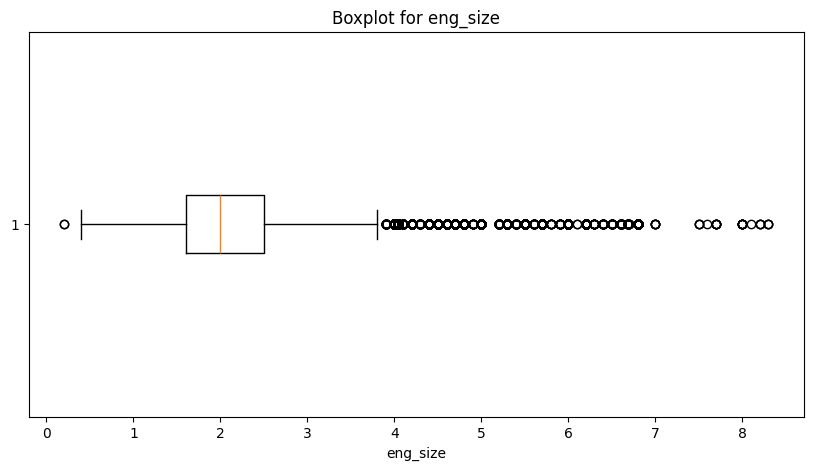

Столбец: eng_power
Уникальные значения:


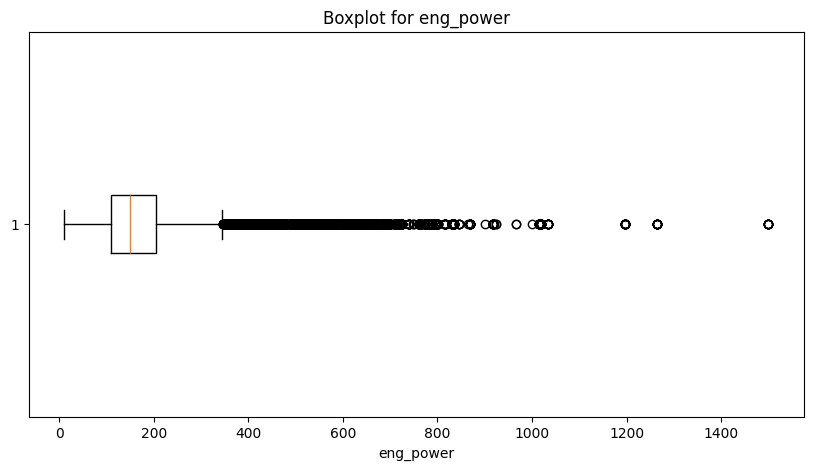

Столбец: eng_type
Уникальные значения:
Столбец: options
Уникальные значения:
Столбец: transmission
Уникальные значения:
Столбец: drive
Уникальные значения:
Столбец: st_wheel
Уникальные значения:
Столбец: condition
Уникальные значения:
Столбец: count_owner
Уникальные значения:
Столбец: original_pts
Уникальные значения:
Столбец: customs
Уникальные значения:
Столбец: url_compl
Уникальные значения:
Столбец: state_mark
Уникальные значения:
Столбец: class_auto
Уникальные значения:
Столбец: door_count
Уникальные значения:


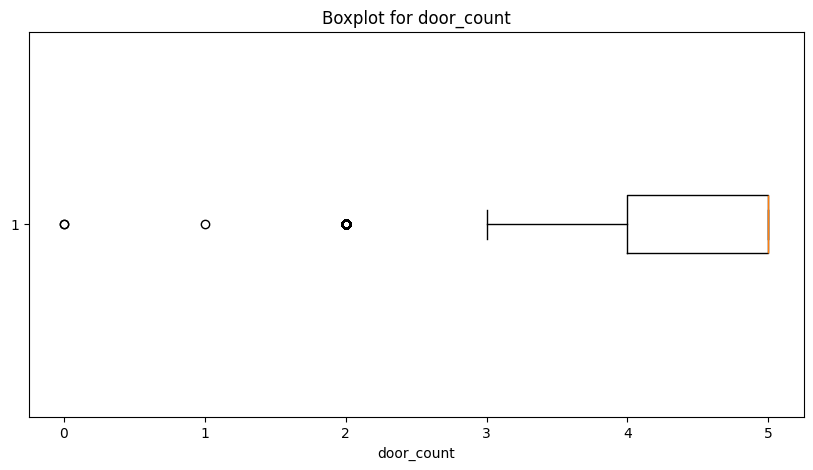

Столбец: seat_count
Уникальные значения:


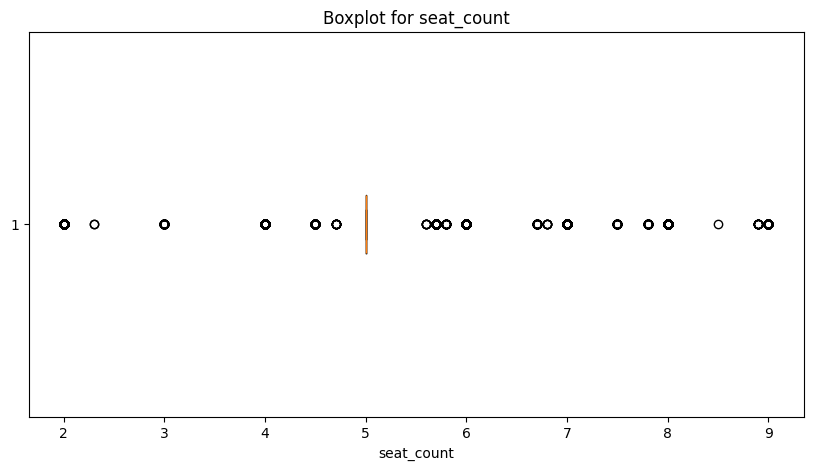

Столбец: long
Уникальные значения:


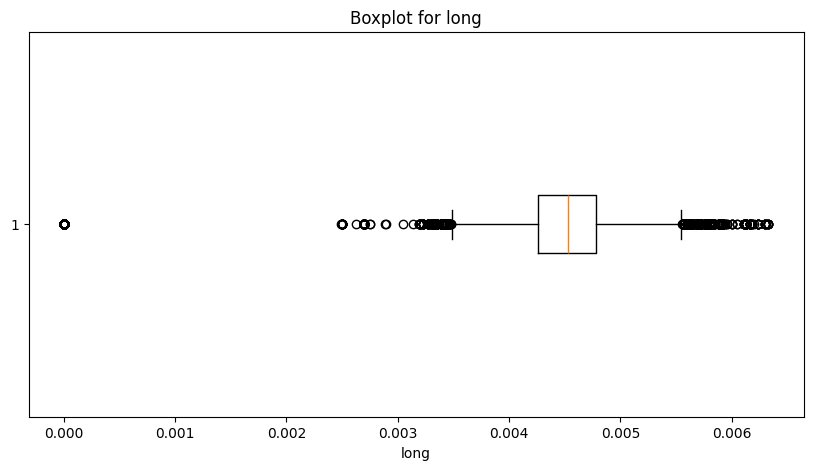

Столбец: widht
Уникальные значения:


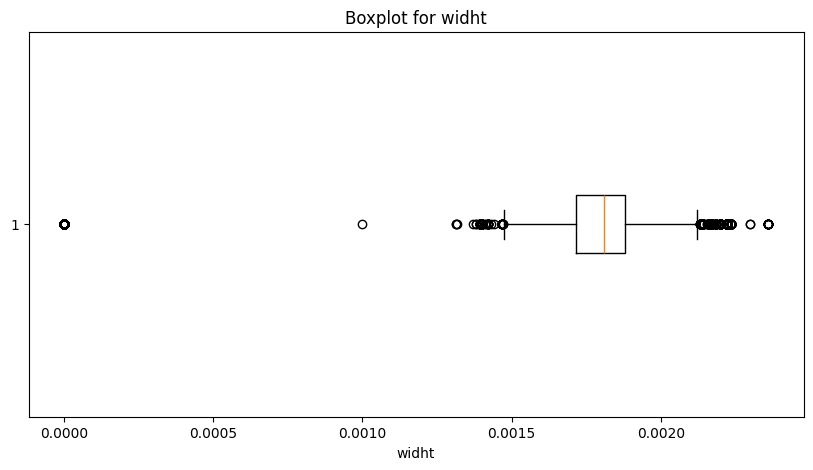

Столбец: height
Уникальные значения:


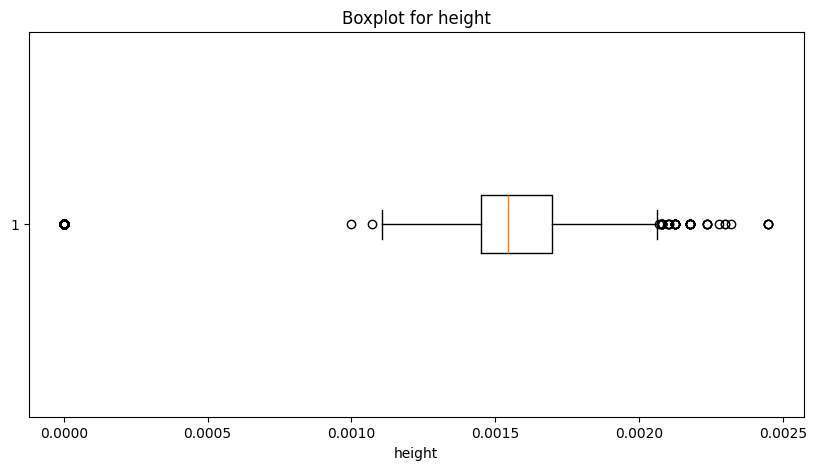

Столбец: clearence
Уникальные значения:


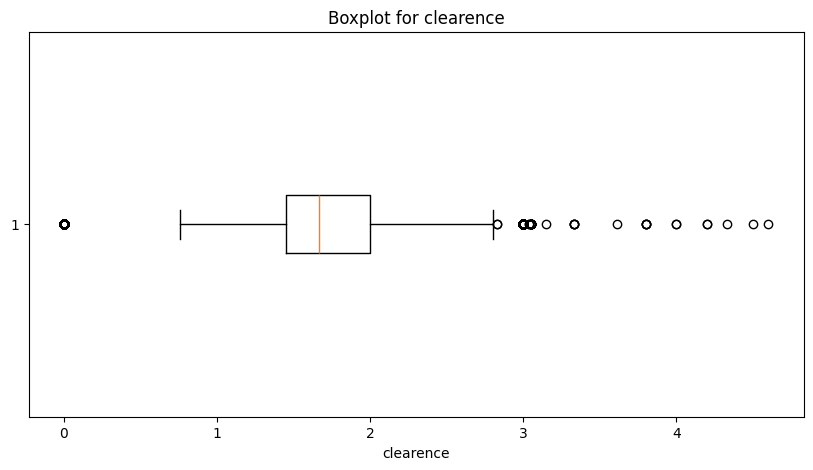

Столбец: v_bag
Уникальные значения:


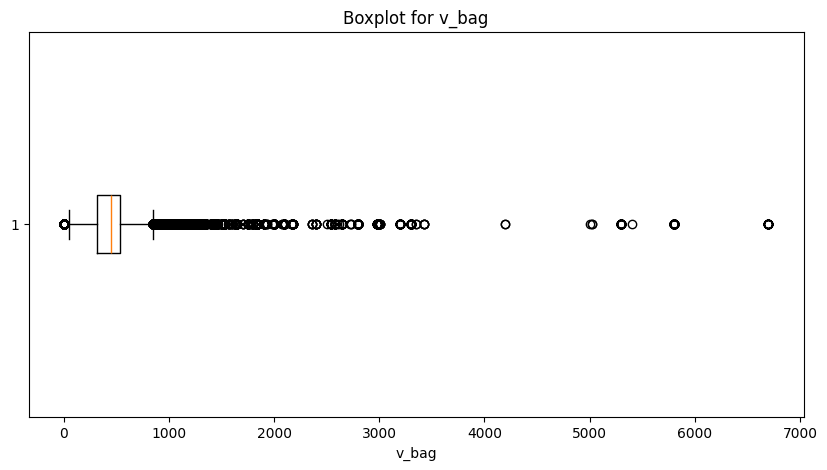

Столбец: v_tank
Уникальные значения:


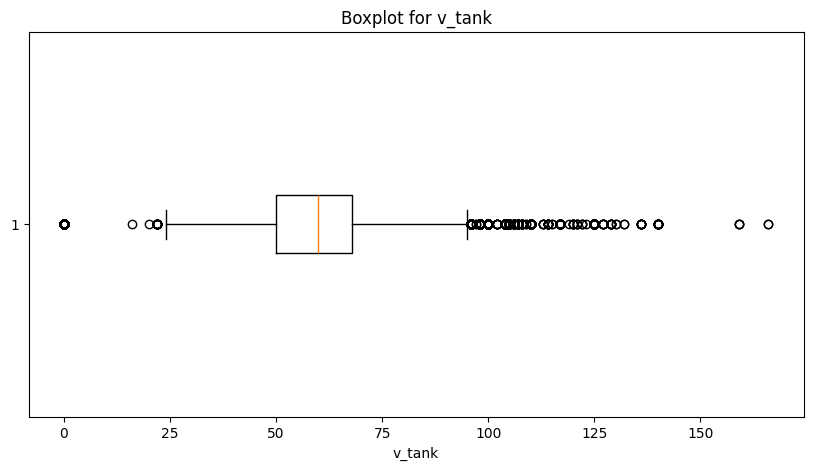

Столбец: curb_weight
Уникальные значения:


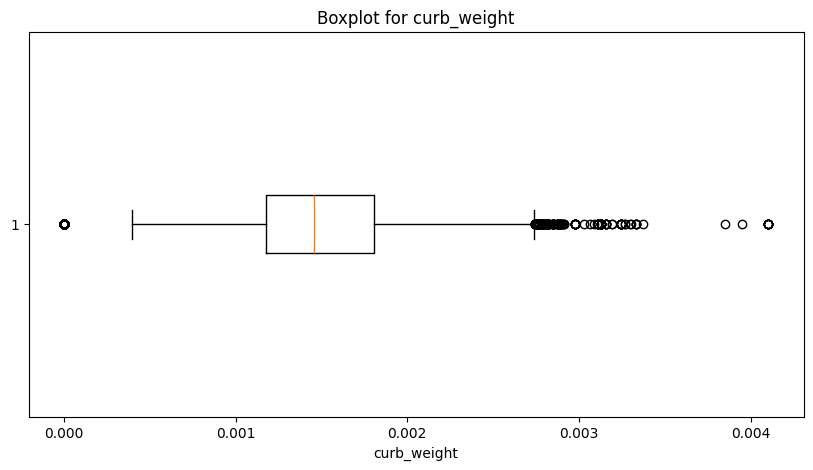

Столбец: gross_weight
Уникальные значения:


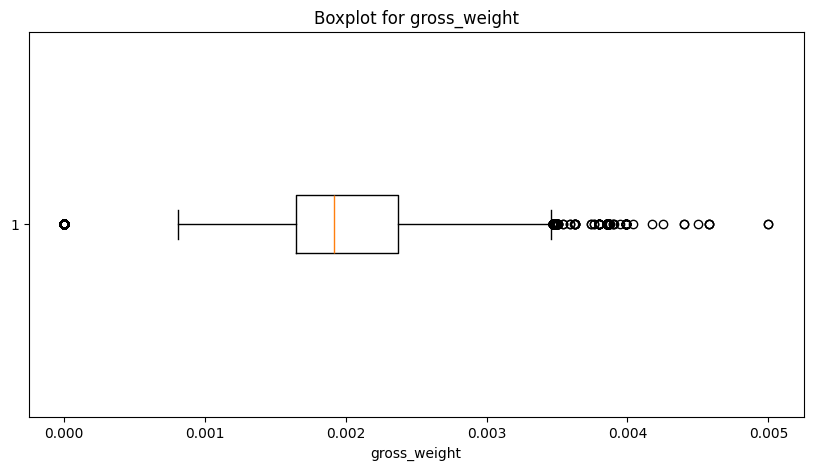

Столбец: front_brakes
Уникальные значения:
Столбец: rear_brakes
Уникальные значения:
Столбец: max_speed
Уникальные значения:


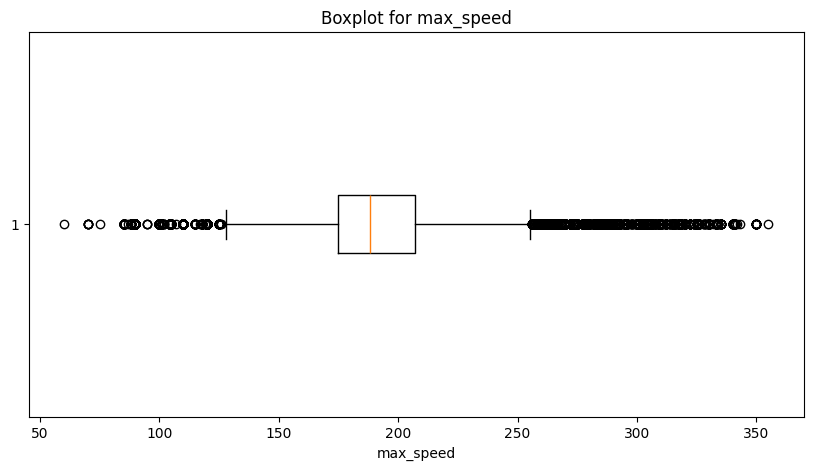

Столбец: acceleration
Уникальные значения:


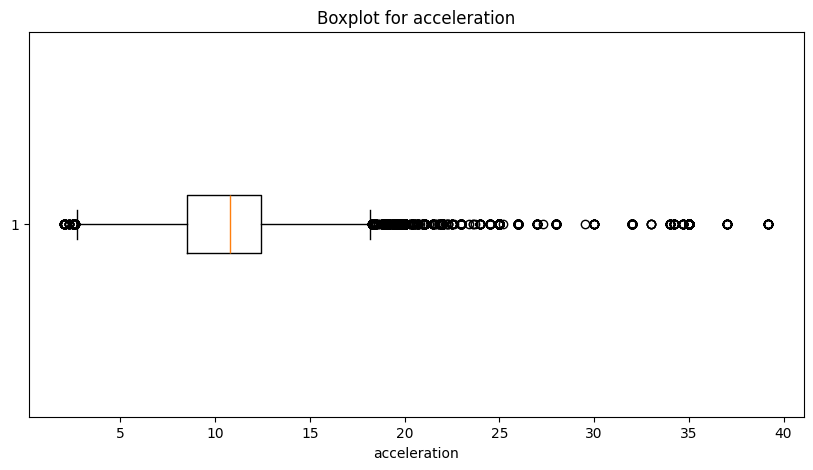

Столбец: fuel_cons
Уникальные значения:


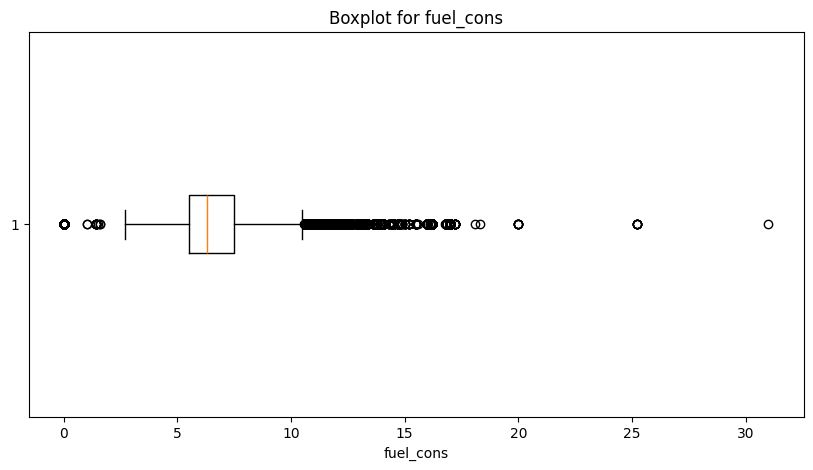

Столбец: fuel_brand
Уникальные значения:
Столбец: turbocharg
Уникальные значения:
Столбец: max_torq
Уникальные значения:


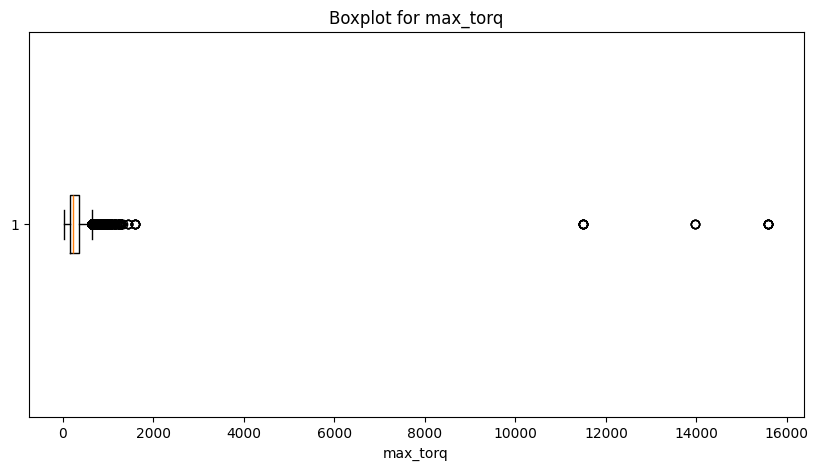

Столбец: cyl_count
Уникальные значения:


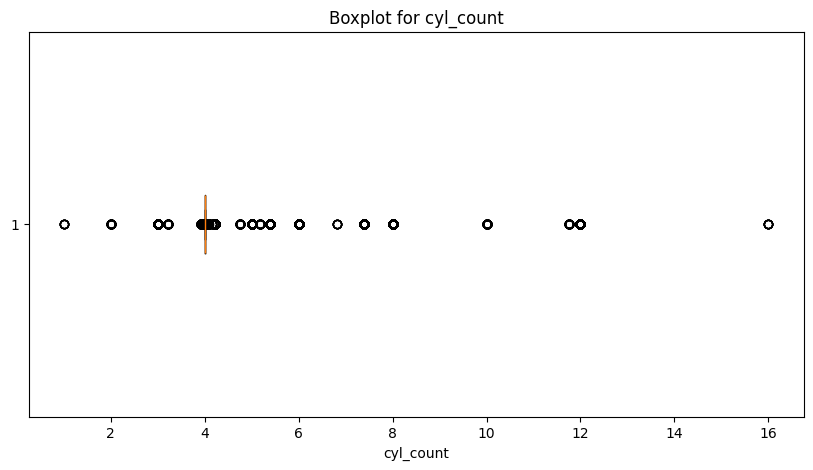

In [68]:
def analyze_columns(data, columns):
    for col in columns:
        print(f"Столбец: {col}")
        print("Уникальные значения:")
        #print(data[col].sort_values().unique())
        

        if data[col].dtype in ['int64', 'float64']:
            plt.figure(figsize=(10, 5))
            plt.boxplot(data[col].dropna(), vert=False)
            plt.title(f'Boxplot for {col}')
            plt.xlabel(col)
            plt.show()

analyze_columns(df, df.columns)


In [69]:
df[df['car_price']<70000].head()

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,turbocharg,max_torq,cyl_count
34,https://auto.ru/cars/used/sale/dodge/stratus/1...,Dodge,Stratus,II,Седан,2.7AT(203л.с.),2024-01-02,1121814232,60000,Минск,https://auto.ru/catalog/cars/dodge/stratus/492...,Вналичии,2001,3.250000e-01,серебристый,2.7,203,Бензин,12опций,автоматическая,передний,Левый,Нетребуетремонта,2владельца,Оригинал,Растаможен,https://auto.ru/catalog/cars/dodge/stratus/492...,США,E,4,5.0,4.855000e-03,1.795000e-03,1.395000e-03,1.4000,453.0,61.0,1.510000e-03,1.990000e-03,дисковые,дисковые,210.0,9.500000,8.100000,NaN,нет,258.000000,6.0
100809,https://auto.ru/cars/used/sale/smz/s3d/1102180...,СМЗ,С-3Д,1970-1997,Купе,0.4MT(12л.с.),2024-01-15,1102180600,60000,Фрязино,https://auto.ru/catalog/cars/smz/s3d/20351993/...,Вналичии,1972,1.200000e-10,красный,0.4,12,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/smz/s3d/20351993/...,Россия,A,2,2.0,2.595000e-12,1.380000e-12,1.700000e-12,0.0017,0.0,0.0,4.540000e-13,1.184692e-12,барабанные,барабанные,70.0,14.425424,4.520886,gasoline,нет,87.314978,1.0
657,https://auto.ru/cars/used/sale/gaz/31029/11178...,ГАЗ,31029«Волга»,1992-1998,Седан,2.5MT(90л.с.),2024-01-19,1117872145,65000,Кострома,https://auto.ru/catalog/cars/gaz/31029/2035167...,Вналичии,1997,8.060000e-02,белый,2.5,90,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/31029/2035167...,Россия,D,4,5.0,4.885000e-03,1.800000e-03,1.476000e-03,1.5600,500.0,55.0,1.420000e-03,1.800000e-03,барабанные,барабанные,147.0,20.000000,9.300000,NaN,нет,172.000000,4.0
670,https://auto.ru/cars/used/sale/zaz/tavria/1121...,ЗАЗ,1102«Таврия»,1988-2009,Хэтчбек3дв.,11021.1MT(53л.с.),2024-01-19,1121966737,69000,Орёл,https://auto.ru/catalog/cars/zaz/tavria/786939...,Вналичии,1990,5.089630e-01,белый,1.1,53,Бензин,6опций,механическая,передний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/zaz/tavria/786939...,Украина,B,3,5.0,3.708000e-03,1.554000e-03,1.410000e-03,1.6200,250.0,39.0,7.450000e-04,1.145000e-03,дисковые,барабанные,145.0,16.200000,4.600000,NaN,нет,80.000000,4.0
833,https://auto.ru/cars/used/sale/moscvich/2141/1...,Москвич,2141,1986-1998,Хэтчбек5дв.,21412-011.5MT(72л.с.),2024-01-23,1122006152,55000,Краснодар,https://auto.ru/catalog/cars/moscvich/2141/786...,Вналичии,1992,2.200000e-01,красный,1.5,72,Бензин,2опции,механическая,передний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/moscvich/2141/786...,Россия,D,5,5.0,4.350000e-03,1.690000e-03,1.400000e-03,1.4000,370.0,55.0,1.065000e-03,1.465000e-03,дисковые,барабанные,150.0,18.000000,6.146452,NaN,нет,106.000000,4.0


<Axes: >

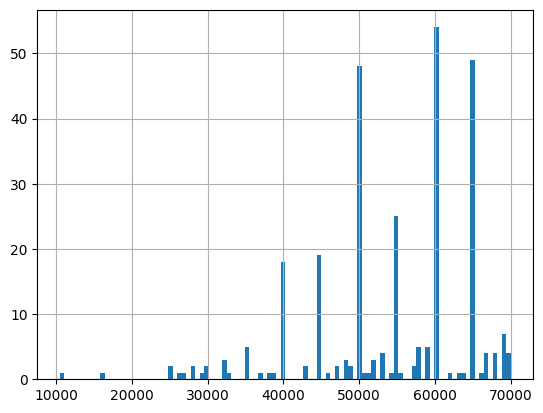

In [70]:
df[df['car_price']<70000]['car_price'].hist(bins = 100)

In [71]:
df['eng_power'].value_counts().sort_index()

eng_power
10       2
12       3
13       2
23       7
25       3
        ..
1020    10
1035     8
1197    19
1265    11
1500     7
Name: count, Length: 515, dtype: int64

In [72]:
df[df['eng_power']>800].head()

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,turbocharg,max_torq,cyl_count
226,https://auto.ru/cars/used/sale/dongfeng/mengsh...,Dongfeng,MengshiM-Hero917,2023-н.в.,Внедорожник5дв.,1.5hybAT(816л.с.)4WD,2024-01-09,1121857480,11280203,Благовещенск,https://auto.ru/catalog/cars/dongfeng/mengshi_...,Назаказ,2023,0.000618,синий,1.500000,816,Гибрид,M-hero,автоматическая,полный,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/dongfeng/mengshi_...,Китай,J,5,5.0,0.004987,0.002080,0.001935,2.210000,452.0,84.0,0.003130,0.003800,дисковые,дисковые,191.000000,6.000000,4.500000,NaN,турбонаддув,1050.000000,4.000000
482,https://auto.ru/cars/used/sale/promo_auto/drag...,Спортивныеавтоиреплики,Драгстер,1950-2024,Купе,2.4MT(1000л.с.),2024-01-15,1083242866,3000000,Ростов-на-Дону,https://auto.ru/catalog/cars/promo_auto/dragst...,Вналичии,1988,0.010000,красный,2.400000,1000,Бензин,1опция,механическая,передний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/promo_auto/dragst...,Россия,S,2,2.0,0.004500,0.001800,0.001500,1.209796,0.0,0.0,0.000600,0.002041,дисковые,дисковые,283.955277,4.767326,7.806160,unknown,нет,532.483088,4.000000
743,https://auto.ru/cars/used/sale/tesla/model_s/1...,Tesla,ModelS,IРестайлинг2,Лифтбек,PlaidElectroAT(761.0кВт)4WD,2024-01-21,1121976739,11740000,Гомель,https://auto.ru/catalog/cars/tesla/model_s/227...,Вналичии,2022,0.007500,белый,4.039626,1020,Электро,ModelS,автоматическая,полный,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/tesla/model_s/227...,США,F,5,5.0,0.004970,0.001964,0.001435,1.440000,793.0,0.0,0.002161,0.002826,дисковые,дисковые,322.000000,2.100000,0.000000,NaN,нет,967.000000,7.389748
921,https://auto.ru/cars/used/sale/byd/yangwang_u8...,BYD,YangwangU8,2023-н.в.,Внедорожник5дв.,2.0hybAT(1197л.с.)4WD,2024-01-25,1122027890,20700000,Москва,https://auto.ru/catalog/cars/byd/yangwang_u8/2...,Вналичии,2023,0.000010,чёрный,2.000000,1197,Гибрид,DeluxeEdition,автоматическая,полный,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/byd/yangwang_u8/2...,Китай,J,5,5.0,0.005319,0.002050,0.001930,2.155942,0.0,75.0,0.002066,0.002695,дисковые,дисковые,170.320364,3.600000,5.340385,NaN,турбонаддув,1280.000000,4.000000
1385,https://auto.ru/cars/used/sale/byd/yangwang_u8...,BYD,YangwangU8,2023-н.в.,Внедорожник5дв.,2.0hybAT(1197л.с.)4WD,2024-02-03,1122130543,20200000,Москва,https://auto.ru/catalog/cars/byd/yangwang_u8/2...,Вналичии,2023,0.000011,зелёный,2.000000,1197,Гибрид,DeluxeEdition,автоматическая,полный,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/byd/yangwang_u8/2...,Китай,J,5,5.0,0.005319,0.002050,0.001930,2.155942,0.0,75.0,0.002066,0.002695,дисковые,дисковые,170.320364,3.600000,5.340385,NaN,турбонаддув,1280.000000,4.000000


Видим, что много строк, где мощность равна нулю или около него, так же есть выборы, где мощность более 1000

<Axes: >

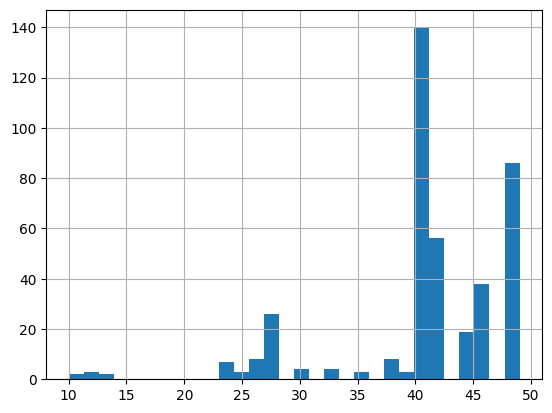

In [73]:
df[df['eng_power']<50]['eng_power'].hist(bins = 30)

In [74]:
df[df['eng_power']<50].head()

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,turbocharg,max_torq,cyl_count
6,https://auto.ru/cars/used/sale/subaru/sambar/1...,Subaru,Sambar,VIIРестайлинг,Микровэн,0.7MT(46л.с.)4WD,2024-01-01,1121810889,1150000,Солнечногорск,https://auto.ru/catalog/cars/subaru/sambar/231...,Вналичии,2019,0.0680,белый,0.7,46,Бензин,2опции,механическая,полный,Правый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/subaru/sambar/231...,Япония,M,5,4.0,0.003395,0.001475,0.001875,1.60,0.0,40.0,0.000960,0.001430,дисковые,барабанные,181.868359,12.27384,6.100000,NaN,нет,60.0,3.0
7,https://auto.ru/cars/used/sale/subaru/sambar/1...,Subaru,Sambar,VIIРестайлинг,Микровэн,0.7MT(46л.с.)4WD,2024-01-01,1121811833,1150000,Солнечногорск,https://auto.ru/catalog/cars/subaru/sambar/231...,Вналичии,2019,0.1080,белый,0.7,46,Бензин,8опций,механическая,полный,Правый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/subaru/sambar/231...,Япония,M,5,4.0,0.003395,0.001475,0.001875,1.60,0.0,40.0,0.000960,0.001430,дисковые,барабанные,181.868359,12.27384,6.100000,NaN,нет,60.0,3.0
61,https://auto.ru/cars/used/sale/moscvich/400/11...,Москвич,400,1946-1956,Кабриолет,400-4201.1MT(23л.с.),2024-01-03,1121820769,1650000,Санкт-Петербург,https://auto.ru/catalog/cars/moscvich/400/2035...,Вналичии,1950,0.0005,красный,1.1,23,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/moscvich/400/2035...,Россия,C,4,4.0,0.003855,0.001400,0.001555,2.00,0.0,31.0,0.000885,0.001155,барабанные,барабанные,90.000000,11.02200,5.112871,NaN,нет,55.0,4.0
110,https://auto.ru/cars/used/sale/suzuki/every/11...,Suzuki,Every,V,Микровэн,0.7AT(49л.с.),2024-01-05,1121827288,470000,Иркутск,https://auto.ru/catalog/cars/suzuki/every/2172...,Вналичии,2012,0.1800,серебристый,0.7,49,Бензин,1опция,автоматическая,задний,Правый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/suzuki/every/2172...,Япония,M,5,4.0,0.003395,0.001475,0.001790,1.50,0.0,40.0,0.001582,0.002294,дисковые,барабанные,181.868359,12.27384,4.994833,NaN,нет,62.0,3.0
111,https://auto.ru/cars/used/sale/zaz/968/1121829...,ЗАЗ,968,1972-1994,Седан2дв.,М1.2MT(40л.с.),2024-01-05,1121829946,135000,Томск,https://auto.ru/catalog/cars/zaz/968/20265169/...,Вналичии,1979,0.0430,жёлтый,1.2,40,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/zaz/968/20265169/...,Украина,B,2,4.0,0.003730,0.001535,0.001370,1.75,0.0,40.0,0.000860,0.001180,барабанные,барабанные,118.000000,35.00000,6.500000,NaN,нет,74.0,4.0


Заметили что есть автомобили с малой мощностью двигателя, но это нормально так как это гибридный автомобиль

Также видим что у нас присутствуют старые автомобили, предлагаю проанализировать их

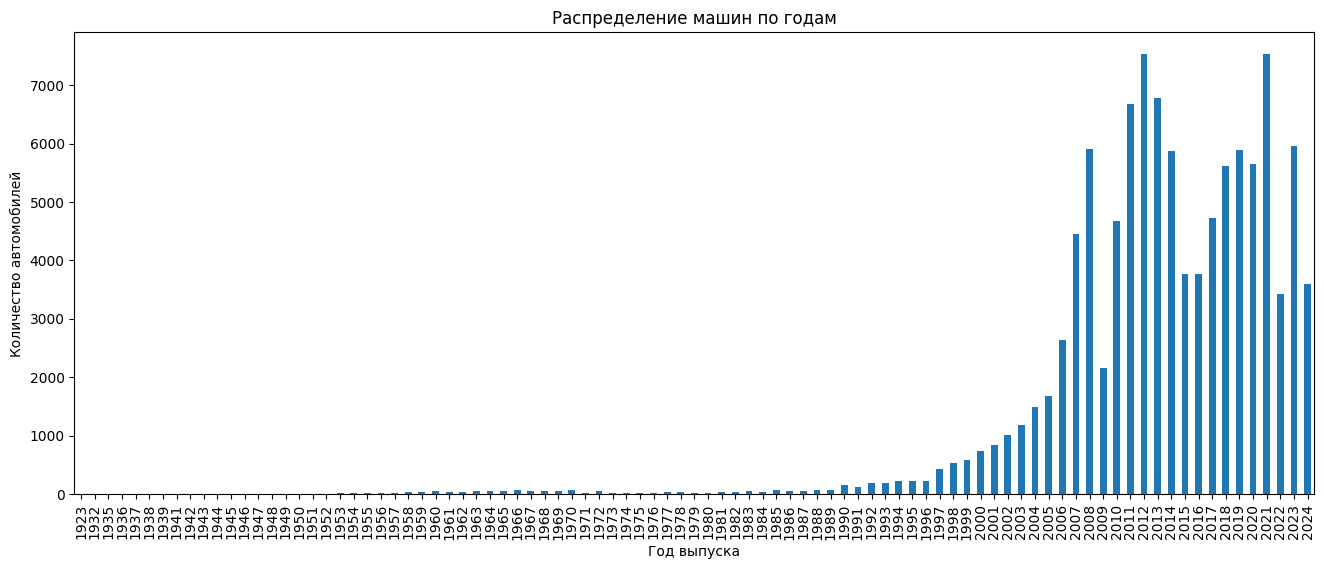

In [75]:
year_dist = df['year'].value_counts().sort_index()
plt.figure(figsize=(16, 6))
year_dist.plot(kind='bar')
plt.title('Распределение машин по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество автомобилей')
plt.show()

In [76]:
df[df['year'] >= 1970]

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,turbocharg,max_torq,cyl_count
0,https://auto.ru/cars/used/sale/uaz/3151/112181...,УАЗ,3151,1985-2013,Внедорожник5дв.,315192.9MT(84л.с.)4WD,2024-01-01,1121811096,500000,Чехов,https://auto.ru/catalog/cars/uaz/3151/7869981/...,Вналичии,2005,0.12500,серебристый,2.9,84,Бензин,2опции,механическая,полный,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/uaz/3151/7869981/...,Россия,J,5,7.0,0.004025,0.001785,0.002020,2.20,900.0,78.0,0.001750,0.002500,дисковые,барабанные,120.0,13.23339,16.2,NaN,нет,189.0,4.0
18,https://auto.ru/cars/used/sale/vaz/2109/112181...,Lada(ВАЗ),2109,1987-2006,Хэтчбек5дв.,1.6MT(81л.с.),2024-01-01,1121810838,650000,Обнинск,https://auto.ru/catalog/cars/vaz/2109/6256996/...,Вналичии,2011,1.00000,синий,1.6,81,Бензин,1опция,механическая,передний,Левый,Нетребуетремонта,2владельца,Оригинал,Растаможен,https://auto.ru/catalog/cars/vaz/2109/6256996/...,Россия,B,5,5.0,0.004006,0.001650,0.001402,1.65,270.0,43.0,0.000945,0.001370,дисковые,барабанные,165.0,14.00000,5.7,NaN,нет,120.0,4.0
17,https://auto.ru/cars/used/sale/geely/coolray/1...,Geely,Coolray,I,Внедорожник5дв.,1.5AMT(150л.с.),2024-01-01,1121810351,2370000,Иркутск,https://auto.ru/catalog/cars/geely/coolray/218...,Вналичии,2022,0.02998,красный,1.5,150,Бензин,FlagshipSport,роботизированная,передний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/geely/coolray/218...,Китай,B,5,5.0,0.004330,0.001800,0.001609,1.90,330.0,45.0,0.001415,0.001715,дисковые,дисковые,190.0,8.40000,5.4,NaN,турбонаддув,255.0,3.0
16,https://auto.ru/cars/used/sale/peugeot/3008/11...,Peugeot,3008,I,Внедорожник5дв.,1.6MT(120л.с.),2024-01-01,1121811069,795000,Кропоткин,https://auto.ru/catalog/cars/peugeot/3008/6391...,Вналичии,2013,0.23100,белый,1.6,120,Бензин,Access,механическая,передний,Левый,Нетребуетремонта,2владельца,Оригинал,Растаможен,https://auto.ru/catalog/cars/peugeot/3008/6391...,Франция,C,5,5.0,0.004365,0.001837,0.001639,1.70,432.0,60.0,0.001474,0.002000,дисковые,дисковые,185.0,11.80000,5.6,NaN,нет,160.0,4.0
15,https://auto.ru/cars/used/sale/land_rover/rang...,LandRover,RangeRover,IIIРестайлинг2,Внедорожник5дв.,Supercharged5.0AT(510л.с.)4WD,2024-01-01,1121810411,1300000,Ульяновск,https://auto.ru/catalog/cars/land_rover/range_...,Вналичии,2011,0.24000,белый,5.0,510,Бензин,Westminster,автоматическая,полный,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/land_rover/range_...,Великобритания,J,5,5.0,0.004972,0.002034,0.001877,2.30,535.0,104.0,0.002590,0.002695,дисковые,дисковые,225.0,6.20000,10.7,NaN,компрессор,625.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100719,https://auto.ru/cars/used/sale/peugeot/travell...,Peugeot,Traveller,I,МинивэнLong,Long1.6dMT(115л.с.),2024-12-31,1117745242,3048262,Минск,https://auto.ru/catalog/cars/peugeot/traveller...,Вналичии,2017,0.20400,чёрный,1.6,115,Дизель,1опция,механическая,передний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/peugeot/traveller...,Франция,M,5,6.0,0.005308,0.001920,0.001905,1.50,989.0,69.0,0.001611,0.002730,дисковые,дисковые,160.0,13.40000,5.0,NaN,турбонаддув,300.0,4.0
100720,https://auto.ru/cars/used/sale/land_rover/rang...,LandRover,RangeRoverSport,I,Внедорожник5дв.,3.6dAT(272л.с.)4WD,2024-12-31,1121808855,1399000,Кореновск,https://auto.ru/catalog/cars/land_rover/range_...,Вналичии,2006,0.21300,синий,3.6,272,Дизель,HSE,автоматическая,полн

Обработаю часть стобцов, чтобы в дальнейшем удобно работать с кодированием

In [77]:
print('Удалено данных:', f"{1-len(df)/len1:.2%}", 'или', len1- len(df), 'строк')   

Удалено данных: 11.10% или 13501 строк


### 1.2 Подготовка к обучению

Линейная модель со стандартизацией признаков:

In [78]:
label_columns = ['car_make', 'car_model', 'car_type', 'state_mark', 'class_auto']

ordinal_columns = ['color', 'ann_city']  

ohe_columns = ['eng_type', 'transmission', 'drive', 'st_wheel',
               'count_owner', 'original_pts', 'front_brakes',
                'rear_brakes', 'turbocharg', 'fuel_brand', 'avail', 'condition' ]

df_ohe = pd.get_dummies(df, columns=ohe_columns, drop_first=True)


label_encoder = LabelEncoder()
for col in label_columns:
    df_ohe[col] = label_encoder.fit_transform(df_ohe[col])


ordinal_encoder = OrdinalEncoder()
df_ohe[ordinal_columns] = ordinal_encoder.fit_transform(df_ohe[ordinal_columns])


columns_to_drop = ['url_car' , 'car_gen', 'car_compl',
        'ann_date', 'ann_id', 'ann_city', 'link_cpl',
        'mileage', 'color','options', 'customs','url_compl', 
         'door_count', 'seat_count', 'height',
         'clearence', 'v_bag', 'gross_weight', 'max_speed', 'fuel_cons']
df_ohe.drop(columns=columns_to_drop, errors='ignore', inplace=True)

In [79]:
df_ohe = df_ohe.copy()

In [80]:
X = df_ohe.drop('car_price', axis=1)
y = df_ohe['car_price']

In [81]:
df_ohe = df_ohe.replace({True: 1, False: 0})

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [83]:
df_ohe

,car_make,car_model,car_type,car_price,year,eng_size,eng_power,state_mark,class_auto,long,widht,v_tank,curb_weight,acceleration,max_torq,cyl_count,eng_type_Газ,eng_type_Гибрид,eng_type_Гибрид.газобаллонноеоборудование,eng_type_Дизель,eng_type_Электро,transmission_вариатор,transmission_механическая,transmission_роботизированная,drive_передний,drive_полный,st_wheel_Правый,count_owner_2владельца,count_owner_3илиболее,original_pts_Оригинал,front_brakes_дисковые,front_brakes_керамические,rear_brakes_дисковые,rear_brakes_керамические,turbocharg_нет,turbocharg_турбонаддув,fuel_brand_diesel,fuel_brand_gasoline,fuel_brand_unknown,avail_Впути,avail_Назаказ
0,213,114,8,500000,2005,2.9,84,12,6,0.004025,0.001785,78.0,0.001750,13.23339,189.0,4.0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0
18,87,67,250,650000,2011,1.6,81,12,1,0.004006,0.001650,43.0,0.000945,14.00000,120.0,4.0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0
17,75,531,8,2370000,2022,1.5,150,7,1,0.004330,0.001800,45.0,0.001415,8.40000,255.0,3.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0
16,131,99,8,795000,2013,1.6,120,19,2,0.004365,0.001837,60.0,0.001474,11.80000,160.0,4.0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0
15,90,1372,8,1300000,2011,5.0,510,2,6,0.004972,0.002034,104.0,0.002590,6.20000,625.0,8.0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100720,90,1374,8,1399000,2006,3.6,272,2,6,0.004790,0.001930,88.0,0.002575,9.20000,640.0,8.0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0
100721,213,1247,8,1150000,2016,2.7,135,12,6,0.004750,0.001900,68.0,0.002125,20.00000,217.0,4.0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0
100722,21,1801,8,3980000,2017,3.0,360,3,3,0.004708,0.001891,65.0,0.001810,4.80000,500.0,6.0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0
100723,38,413,243,450000,2006,1.6,109,19,2,0.004274,0.001769,60.0,0.001275,13.10000,147.0,4.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0


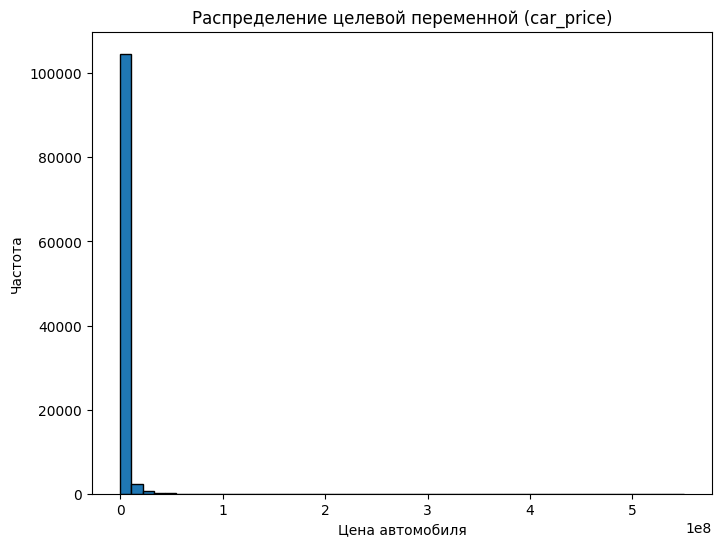

,count,mean,std,min,25%,50%,75%,max
car_make,108107.0,111.460636,55.663254,0.000000e+00,68.000000,116.000000,159.000000,213.000000
car_model,108107.0,955.057536,526.766204,0.000000e+00,493.000000,989.000000,1372.000000,1926.000000
car_type,108107.0,98.157964,93.119178,0.000000e+00,8.000000,80.000000,173.000000,270.000000
year,108107.0,2013.278715,8.499487,1.923000e+03,2010.000000,2014.000000,2019.000000,2024.000000
eng_size,108107.0,2.133958,0.919970,2.000000e-01,1.600000,2.000000,2.500000,8.300000
eng_power,108107.0,179.804471,113.901636,1.000000e+01,110.000000,150.000000,204.000000,1500.000000
state_mark,108107.0,14.254951,7.912226,0.000000e+00,7.000000,14.000000,22.000000,23.000000
class_auto,108107.0,3.112601,1.897909,0.000000e+00,2.000000,3.000000,4.000000,9.000000
long,108107.0,0.004029,0.001514,2.499000e-12,0.004260,0.004531,0.004779,0.006330
widht,108107.0,0.001610,0.000597,1.380000e-12,0.001717,0.001810,0.001880,0.002360


In [84]:
plt.figure(figsize=(8, 6))
plt.hist(y, bins=50, edgecolor='k')
plt.title('Распределение целевой переменной (car_price)')
plt.xlabel('Цена автомобиля')
plt.ylabel('Частота')
plt.show()

X.describe().T

Смещение вправо: Распределение цены автомобилей сильно скошено вправо, что говорит о наличии большого числа автомобилей с относительно низкой стоимостью, а также нескольких автомобилей с очень высокой стоимостью. Что логично в моем случае т.к. есть такие модели авто. Можно попробовать применить логарифмическое преобразование к цене автомобилей перед обучением модели и сравнить.

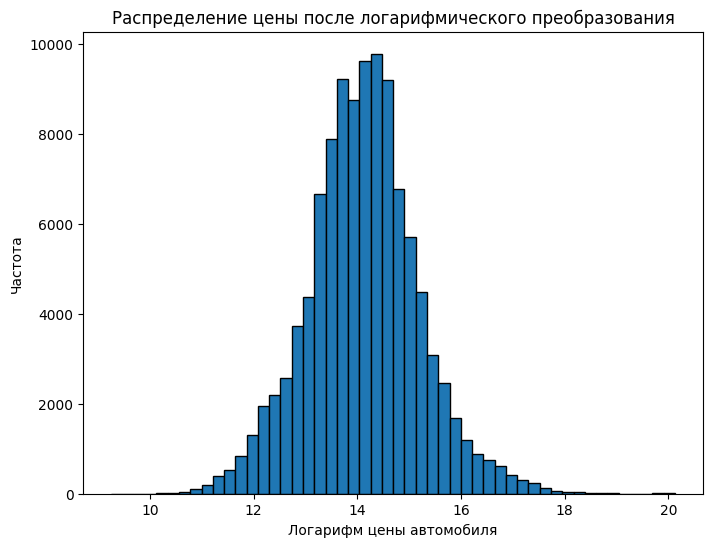

In [85]:
y_log = np.log1p(y)
plt.figure(figsize=(8, 6))
plt.hist(y_log, bins=50, edgecolor='black')
plt.title('Распределение цены после логарифмического преобразования')
plt.xlabel('Логарифм цены автомобиля')
plt.ylabel('Частота')
plt.show()

## 2. Обучение моделей



### 2.1 LinearRegression


In [86]:
%%time

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

y_pred = model_lr.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

coeffs_lr = model_lr.coef_
coeffs_df_lr = pd.DataFrame({'Признак': X.columns, 'Веса': coeffs_lr}).sort_values(by='Веса', ascending=False)


y_train_pred = model_lr.predict(X_train_scaled)
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

print('Linear Regression:')
print('R^2 (train):', r2_train)
print('MSE (train):', mse_train)
print('R^2 (test):', r2)
print('MSE (test):', mse)
print(coeffs_df_lr)

Linear Regression:
R^2 (train): 0.397170275313408
MSE (train): 25389209366727.293
R^2 (test): 0.48302849763918165
MSE (test): 19348300000762.145
                                      Признак          Веса
5                                   eng_power  3.415904e+06
9                                       widht  2.037219e+06
14                                  cyl_count  1.689145e+06
34                     turbocharg_турбонаддув  1.290314e+06
33                             turbocharg_нет  1.068050e+06
3                                        year  8.725108e+05
12                               acceleration  7.903714e+05
32                   rear_brakes_керамические  6.009997e+05
36                        fuel_brand_gasoline  5.531988e+05
7                                  class_auto  3.858769e+05
18                            eng_type_Дизель  3.743185e+05
21                  transmission_механическая  2.364997e+05
30                  front_brakes_керамические  2.304228e+05
6              

### LinearRegression с логарифмическим преобразованим

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

model_log = LinearRegression(random_state=42)
model_log.fit(X_train_scaled, y_train_log)

y_pred_log = model_log.predict(X_test_scaled)

y_pred = np.expm1(y_pred_log)

r2_log = r2_score(y_test, y_pred)
mse_log = mean_squared_error(y_test, y_pred)

coeffs_log = model_log.coef_
coeffs_df_log = pd.DataFrame({'Признак': X.columns, 'Веса': coeffs_log}).sort_values(by='Веса', ascending=False)


y_train_pred_log = model_log.predict(X_train_scaled)
y_train_pred = np.expm1(y_train_pred_log)

r2_train_log = r2_score(y_train, y_train_pred)
mse_train_log = mean_squared_error(y_train, y_train_pred)

print('Linear Regression (log):')
print('R^2 (train):', r2_train_log)
print('MSE (train):', mse_train_log)
print('R^2 (test):', r2_log)
print('MSE (test):', mse_log)
print(coeffs_df_log)

Linear Regression (log):
R^2 (train): 0.6099652461138878
MSE (train): 16426983642624.457
R^2 (test): 0.6868520713740933
MSE (test): 11719949823157.799
                                      Признак      Веса
9                                       widht  0.495058
3                                        year  0.482005
36                        fuel_brand_gasoline  0.233647
5                                   eng_power  0.224507
4                                    eng_size  0.157642
34                     turbocharg_турбонаддув  0.113124
11                                curb_weight  0.089571
31                       rear_brakes_дисковые  0.086488
7                                  class_auto  0.082244
35                          fuel_brand_diesel  0.063051
33                             turbocharg_нет  0.057701
18                            eng_type_Дизель  0.050247
0                                    car_make  0.049037
28                      original_pts_Оригинал  0.034256
6        

 Выводы

 Логарифмическая регрессия показывает лучший показатель \( R^2 \)
- \( R^2 \): 0.749 против 0.646 в обычной линейной регрессии.
- Это свидетельствует о лучшем объяснении дисперсии целевой переменной моделью.

 Преимущества логарифмического преобразования
- Логарифмическое преобразование устраняет сильное смещение распределения целевой переменной.
- Уменьшает влияние выбросов, что способствует повышению точности модели.

Важные признаки
- Оба подхода выделяют важность следующих признаков: `fuel_brand_gas`, `year`, `eng_power`, `car_make`



### Модель Lasso с кросс валидацией со стандартизацией признаков

In [ ]:
%%time

grid = {'alpha': np.logspace(-3, 6, 50)}
lasso = Lasso(random_state=42, max_iter=700)
grid_search = GridSearchCV(estimator = lasso, 
                           param_grid = grid, 
                           scoring = 'r2',
                           cv = 4,
                           n_jobs=-1
                           )

grid_search.fit(X_train_scaled, y_train)
lasso_grid_model = grid_search.best_estimator_

y_pred = lasso_grid_model.predict(X_train_scaled)
r2_lasso_grid = r2_score(y_train, y_pred)
mse_lasso_grid = mean_squared_error(y_train, y_pred)

print('Lasso_cross:')
print('R^2:' , r2_lasso_grid)
print('MSE:' , mse_lasso_grid)
print('best_params:', grid_search.best_params_)

Lasso_cross:
R^2: 0.3969258996302806
MSE: 25399501668398.85
best_params: {'alpha': 4094.9150623804276}
CPU times: total: 12.4 s
Wall time: 1min 48s


In [89]:
%%time

grid_elastic = {'alpha': np.logspace(-3, 6, 100),
                'l1_ratio': np.linspace(0.1 , 1, 10) 
}

elastic = ElasticNet(random_state=42)

grid_search_elastic = GridSearchCV(
        estimator = elastic, 
        param_grid = grid_elastic, 
        scoring = 'r2',
        cv = 4, 
        n_jobs = -1, 
        verbose = 1
)

grid_search_elastic.fit(X_train_scaled, y_train)
grid_model_elastic = grid_search_elastic.best_estimator_

y_pred = grid_model_elastic.predict(X_train_scaled)
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)

coeffs_elast_grid = grid_model_elastic.coef_
coeffs_df_log = pd.DataFrame({'Признак': X.columns, 'Веса': coeffs_elast_grid}).sort_values(by='Веса', ascending=False)

print('ElasticNet:')
print('R^2:' , r2)
print('MSE:' , mse)
print('best_params:', grid_search_elastic.best_params_)
print(coeffs_df_log)

Fitting 4 folds for each of 3000 candidates, totalling 12000 fits
ElasticNet:
R^2: 0.39421011456960653
MSE: 25513881621272.496
best_params: {'alpha': 0.04328761281083059, 'l1_ratio': 0.28620689655172415}
                                      Признак          Веса
5                                   eng_power  2.770847e+06
14                                  cyl_count  1.540847e+06
3                                        year  8.523660e+05
32                   rear_brakes_керамические  6.225467e+05
12                               acceleration  5.844732e+05
34                     turbocharg_турбонаддув  4.662828e+05
9                                       widht  4.427259e+05
7                                  class_auto  3.287748e+05
30                  front_brakes_керамические  3.224204e+05
18                            eng_type_Дизель  2.491867e+05
21                  transmission_механическая  2.269212e+05
13                                   max_torq  2.100128e+05
33              

### Ridge:

In [90]:
%%time

grid_ridge = {'alpha': np.logspace(-5, 6, 100)}

ridge = Ridge(random_state=42)
grid_search_ridge = GridSearchCV(estimator = ridge, 
                                 param_grid = grid_ridge, 
                                 scoring = 'r2', 
                                 cv = 4
                                 )

grid_search_ridge.fit(X_train_scaled, y_train)
grid_model_ridge = grid_search_ridge.best_estimator_

y_pred = grid_model_ridge.predict(X_train_scaled)
r2_ridg = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)

print('Ridge:')
print('R^2:' , r2)
print('MSE:' , mse)
print('best_params:', grid_search_ridge.best_params_['alpha'])

Ridge:
R^2: 0.39421011456960653
MSE: 25465769398562.266
best_params: 1668.1005372000557
CPU times: total: 2.02 s
Wall time: 14.4 s


### 2.2 LightGBM 

In [91]:
%%time

lgb_model = LGBMRegressor(    
    n_estimators=500,
    max_depth=12,  
    min_data_in_leaf=5,
    min_gain_to_split=0.01,     
    learning_rate=0.05,
    random_state=42
    )
lgb_model.fit(X_train_scaled, y_train)

y_pred_lgb = lgb_model.predict(X_test_scaled)

r2_lgb = r2_score(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)

print('LightGBM:')
print('R^2:', r2_lgb)
print('MSE:', mse_lgb)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2491
[LightGBM] [Info] Number of data points in the train set: 81080, number of used features: 39
[LightGBM] [Info] Start training from score 2571661.967760
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current va

### LightGBM с использованием GridSearchCV 

In [92]:
%%time

lgb_params = {
    "max_depth": [-1, 10, 15],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [100, 200],
    "num_leaves": [31, 50, 70],
    "min_child_samples": [5, 10, 20],
    "min_child_weight": [1e-3, 1e-2],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "lambda_l1": [0.0, 0.1],
    "lambda_l2": [0.0, 0.1],
}

lgb_model = LGBMRegressor(random_state=42, verbose=0)

lgb_grid_model = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_params,
    cv=4,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

lgb_grid_model.fit(X_train_scaled, y_train)

best_model_lgb_grid = lgb_grid_model.best_estimator_

y_pred_lgb_test = best_model_lgb_grid.predict(X_test_scaled)
y_pred_lgb_train = best_model_lgb_grid.predict(X_train_scaled)

r2_test_lgb_grid = r2_score(y_test, y_pred_lgb_test)
mse_test_lgb_grid = mean_squared_error(y_test, y_pred_lgb_test)

r2_train_lgb_grid = r2_score(y_train, y_pred_lgb_train)
mse_train_lgb_grid = mean_squared_error(y_train, y_pred_lgb_train)


print('LightGBM_grid Best Parameters:', lgb_grid_model.best_params_)
print('R^2 (train):', r2_train_lgb_grid )
print('MSE (train):', mse_train_lgb_grid)
print('R^2 (test):', r2_test_lgb_grid)
print('MSE (test):', mse_test_lgb_grid)

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
LightGBM_grid Best Parameters: {'colsample_bytree': 0.8, 'lambda_l1': 0.0, 'lambda_l2': 0.1, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 5, 'min_child_weigh

 Разница между треин и  тест (LightGBM с GridSearchCV)

In [93]:
r2_diff_lgb_grid = r2_train_lgb_grid - r2_test_lgb_grid
mse_diff_lgb_grid = mse_train_lgb_grid - mse_test_lgb_grid

print('Разница R^2 (train - test):', r2_diff_lgb_grid)
print('Разница MSE (train - test):', mse_diff_lgb_grid)

Разница R^2 (train - test): 0.05862658759409667
Разница MSE (train - test): -2100907028731.8345


ВАжность признаков (LightGBM с GridSearchCV)

In [94]:
feature_importances_lgb_grid = best_model_lgb_grid.feature_importances_
feature_importances_df_lgb_grid = pd.DataFrame({'Признак': X.columns, 'Важность': feature_importances_lgb_grid}).sort_values(by='Важность', ascending=False)
print(feature_importances_df_lgb_grid)

                                      Признак  Важность
3                                        year       943
5                                   eng_power       488
13                                   max_torq       452
10                                     v_tank       408
12                               acceleration       388
0                                    car_make       369
8                                        long       353
9                                       widht       342
1                                   car_model       329
11                                curb_weight       329
4                                    eng_size       286
6                                  state_mark       242
2                                    car_type       235
39                              avail_Назаказ       156
14                                  cyl_count       155
7                                  class_auto       155
29                      front_brakes_дисковые   

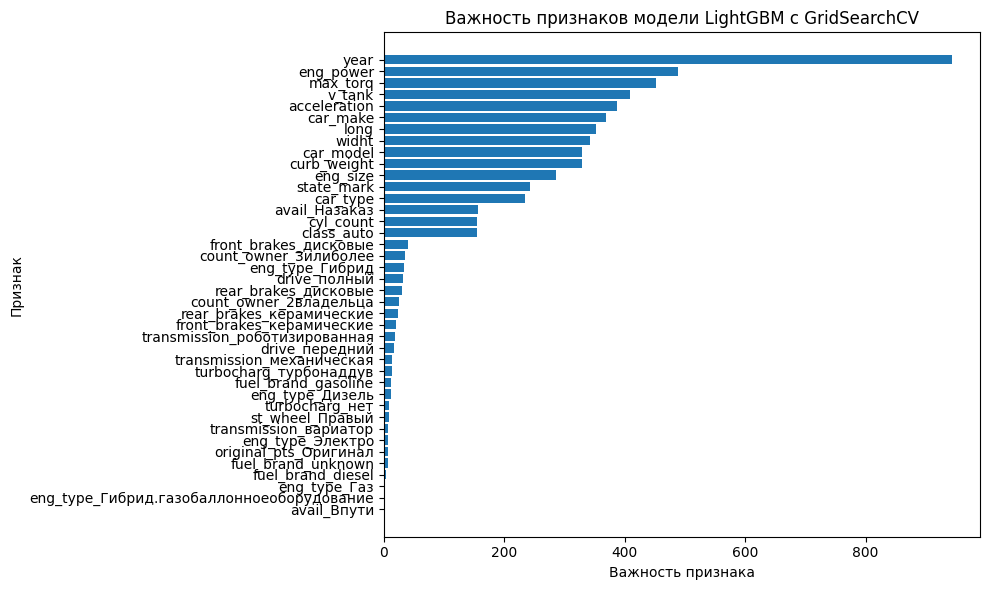

In [95]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_lgb_grid['Признак'], feature_importances_df_lgb_grid['Важность'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков модели LightGBM с GridSearchCV')
plt.tight_layout()
plt.show()

### 2.3  Random Forest

In [96]:
%%time

rf_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=11, 
    random_state=42  
)

rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
feature_importances_rf = rf_model.feature_importances_
feature_importances_df_rf = pd.DataFrame({'Признак': X_train.columns,'Важность': feature_importances_rf}).sort_values(by='Важность', ascending=False)

print("Random Forest:")
print("R^2:", r2_rf)
print("MSE:", mse_rf)


Random Forest:
R^2: 0.9194392229921906
MSE: 3015087049718.454
CPU times: total: 1min 17s
Wall time: 3min 37s


Важность признаков (Random Forest)

In [97]:
feature_importances_rf = rf_model.feature_importances_
feature_importances_df_rf = pd.DataFrame({'Признак': X_train.columns,'Важность': feature_importances_rf}).sort_values(by='Важность', ascending=False)
print(feature_importances_df_rf)

                                      Признак      Важность
5                                   eng_power  3.722851e-01
14                                  cyl_count  1.408547e-01
3                                        year  1.154944e-01
4                                    eng_size  9.757160e-02
13                                   max_torq  8.972724e-02
12                               acceleration  3.016296e-02
0                                    car_make  1.861043e-02
6                                  state_mark  1.760105e-02
1                                   car_model  1.727891e-02
11                                curb_weight  1.337290e-02
7                                  class_auto  1.254595e-02
16                            eng_type_Гибрид  1.042598e-02
8                                        long  8.785793e-03
29                      front_brakes_дисковые  8.107334e-03
9                                       widht  8.091927e-03
30                  front_brakes_керамич

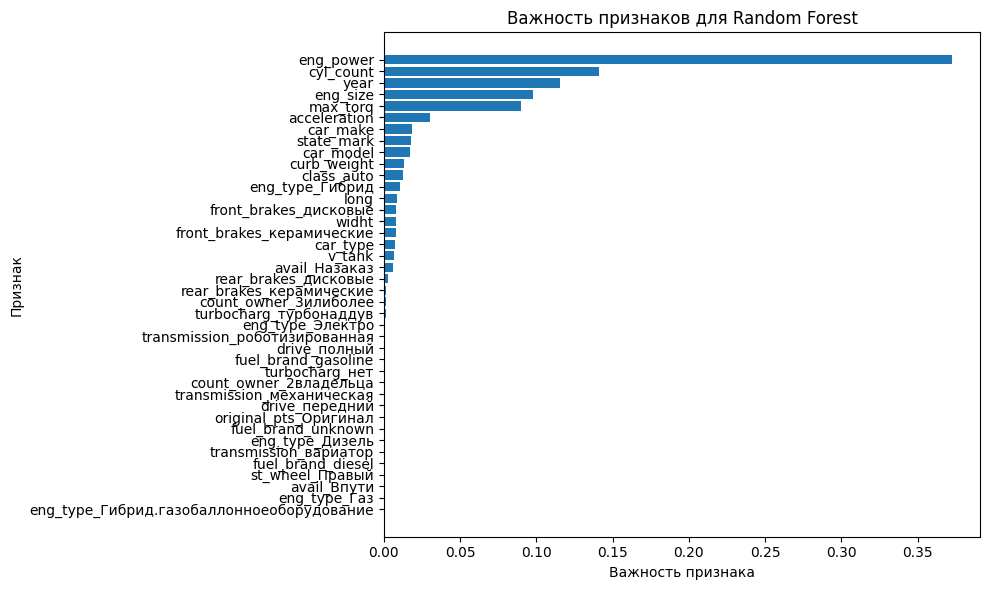

In [98]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_rf['Признак'], feature_importances_df_rf['Важность'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков для Random Forest')
plt.tight_layout()
plt.show()



### RandomForestRegressor c использованием GridSearchCV

In [99]:
%%time

rf_grid_param = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_model = RandomForestRegressor(random_state=42, verbose=0)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_grid_param,
    cv=4,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_model_rf_grid = grid_search.best_estimator_

y_pred_train_rf_grid = best_model_rf_grid.predict(X_train_scaled)

y_pred_test_rf_grid = best_model_rf_grid.predict(X_test_scaled)

r2_train_rfg = r2_score(y_train, y_pred_train_rf_grid)
mse_train_rfg = mean_squared_error(y_train, y_pred_train_rf_grid)

r2_test_rfg = r2_score(y_test, y_pred_test_rf_grid)
mse_test_rfg = mean_squared_error(y_test, y_pred_test_rf_grid)


print("Random_Forest_grid:")
print("Лучшие параметры:", grid_search.best_params_)
print("R^2 (train):", r2_train_rfg)
print("MSE (train):", mse_train_rfg)
print("R^2 (test):", r2_test_rfg)
print("MSE (test):", mse_test_rfg)

Fitting 4 folds for each of 81 candidates, totalling 324 fits
Random_Forest_grid:
Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
R^2 (train): 0.916464194225409
MSE (train): 3518253953936.9995
R^2 (test): 0.9279553281219637
MSE (test): 2696361247355.221
CPU times: total: 30.9 s
Wall time: 1h 2min 44s


 Разница между треин и  тест (RandomForestRegressor c GridSearchCV)

In [100]:
r2_diff_rfg = r2_train_rfg - r2_test_rfg
mse_diff_rfg = mse_train_rfg - mse_test_rfg

print('Разница R^2 (train - test):', r2_diff_rfg)
print('Разница MSE (train - test):', mse_diff_rfg)

Разница R^2 (train - test): -0.01149113389655465
Разница MSE (train - test): 821892706581.7783


Важность признаков (RandomForestRegressor c GridSearchCV)

In [101]:
feature_importances_rf_grid = best_model_rf_grid.feature_importances_
feature_importances_df_rf_grid = pd.DataFrame({'Признак': X.columns,'Важность': feature_importances_rf}).sort_values(by='Важность', ascending=False)
print(feature_importances_df_rf_grid)

                                      Признак      Важность
5                                   eng_power  3.722851e-01
14                                  cyl_count  1.408547e-01
3                                        year  1.154944e-01
4                                    eng_size  9.757160e-02
13                                   max_torq  8.972724e-02
12                               acceleration  3.016296e-02
0                                    car_make  1.861043e-02
6                                  state_mark  1.760105e-02
1                                   car_model  1.727891e-02
11                                curb_weight  1.337290e-02
7                                  class_auto  1.254595e-02
16                            eng_type_Гибрид  1.042598e-02
8                                        long  8.785793e-03
29                      front_brakes_дисковые  8.107334e-03
9                                       widht  8.091927e-03
30                  front_brakes_керамич

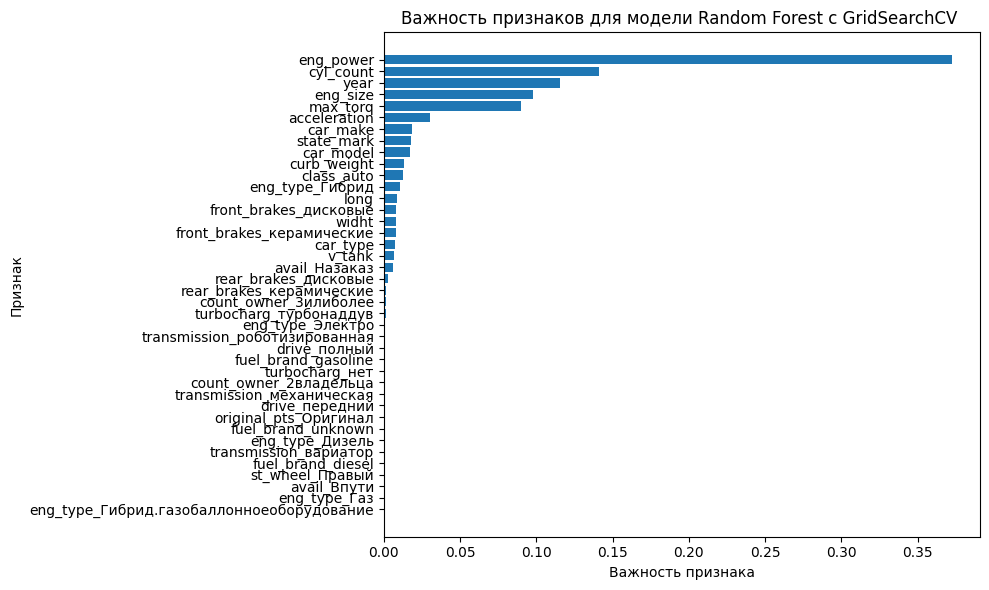

In [102]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_rf_grid['Признак'], feature_importances_df_rf_grid['Важность'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков для модели Random Forest c GridSearchCV ')
plt.tight_layout()
plt.show()

### 2.4 CatBoost

In [103]:
%%time

cat_model = CatBoostRegressor(random_state=42, verbose=0)
cat_model.fit(X_train_scaled, y_train)

y_pred_cat = cat_model.predict(X_test_scaled)
feature_importances_cat = cat_model.get_feature_importance()

feature_importances_df_cat = pd.DataFrame({'Признак': X.columns, 'Важность': feature_importances_cat}).sort_values(by='Важность', ascending=False)

print('CatBoost:')
print('R^2:', r2_score(y_test, y_pred_cat))
print('MSE:', mean_squared_error(y_test, y_pred_cat))
print(feature_importances_df_cat)

CatBoost:
R^2: 0.921410205172227
MSE: 2941320595781.724
                                      Признак      Важность
14                                  cyl_count  2.199722e+01
3                                        year  1.846745e+01
4                                    eng_size  1.042490e+01
13                                   max_torq  8.390987e+00
5                                   eng_power  7.170015e+00
6                                  state_mark  6.183214e+00
12                               acceleration  4.751778e+00
9                                       widht  4.064277e+00
8                                        long  2.298363e+00
31                       rear_brakes_дисковые  2.000154e+00
1                                   car_model  1.988893e+00
7                                  class_auto  1.925767e+00
10                                     v_tank  1.727682e+00
0                                    car_make  1.601693e+00
11                                curb_weigh

### CatBoost с использованием GridSearchCV

In [104]:
%%time

cat_grid_param = {
    'iterations': [500],
    'learning_rate': [0.1],
    'depth': [6],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.1, 0.5, 1],
    'border_count': [32, 64]
}

cat_grid_model = CatBoostRegressor(random_state=42, verbose=0)

grid_search = GridSearchCV(
    estimator=cat_grid_model,
    param_grid=cat_grid_param,
    cv=4,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_model_cat_grid = grid_search.best_estimator_

best_model_cat_grid.fit(X_train_scaled, y_train)

y_pred_test_cat_grid = best_model_cat_grid.predict(X_test_scaled)
y_pred_train_cat_grid = best_model_cat_grid.predict(X_train_scaled)


mse_train_cat_grid = mean_squared_error(y_train, y_pred_train_cat_grid)
r2_train_cat_grid = r2_score(y_train, y_pred_train_cat_grid)

r2_test_cat_grid = r2_score(y_test, y_pred_test_cat_grid)
mse_test_cat_grid = mean_squared_error(y_test, y_pred_test_cat_grid)


print('Лучшие параметры:', best_model_cat_grid.get_params())
print('CatBoost Grid:')
print('R^2 (train):', r2_train_cat_grid)
print('MSE (train):', mse_train_cat_grid)
print('R^2 (test):', r2_test_cat_grid)
print('MSE (test):', mse_test_cat_grid)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
Лучшие параметры: {'loss_function': 'RMSE', 'verbose': 0, 'random_state': 42, 'bagging_temperature': 0.1, 'border_count': 32, 'depth': 6, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
CatBoost Grid:
R^2 (train): 0.972551129940617
MSE (train): 1156056312883.5156
R^2 (test): 0.9113054767168998
MSE (test): 3319502597472.52
CPU times: total: 3.06 s
Wall time: 1min 22s


 Разница между треин и  тест (CatBoost c GridSearchCV)

In [105]:
r2_diff_catr = r2_train_cat_grid - r2_test_cat_grid
mse_diff_catr = mse_train_cat_grid - mse_test_cat_grid

print('Разница R^2 (train - test):', r2_diff_catr)
print('Разница MSE (train - test):', mse_diff_catr)

Разница R^2 (train - test): 0.06124565322371722
Разница MSE (train - test): -2163446284589.0044


Важность признаков (CatBoost с GridSearchCV)

In [106]:
feature_importances_cat_grid = best_model_cat_grid.get_feature_importance()
feature_importances_df_cat_grid = pd.DataFrame({'Признак': X.columns,'Важность': feature_importances_cat_grid}).sort_values(by='Важность', ascending=False)
print(feature_importances_df_cat_grid)

                                      Признак      Важность
14                                  cyl_count  2.366216e+01
3                                        year  2.142721e+01
4                                    eng_size  8.591020e+00
6                                  state_mark  7.692157e+00
13                                   max_torq  6.982034e+00
5                                   eng_power  4.166536e+00
12                               acceleration  3.696823e+00
10                                     v_tank  3.231669e+00
7                                  class_auto  2.707941e+00
0                                    car_make  2.352105e+00
9                                       widht  2.246113e+00
31                       rear_brakes_дисковые  2.086021e+00
1                                   car_model  2.007296e+00
11                                curb_weight  1.850369e+00
29                      front_brakes_дисковые  1.178062e+00
30                  front_brakes_керамич

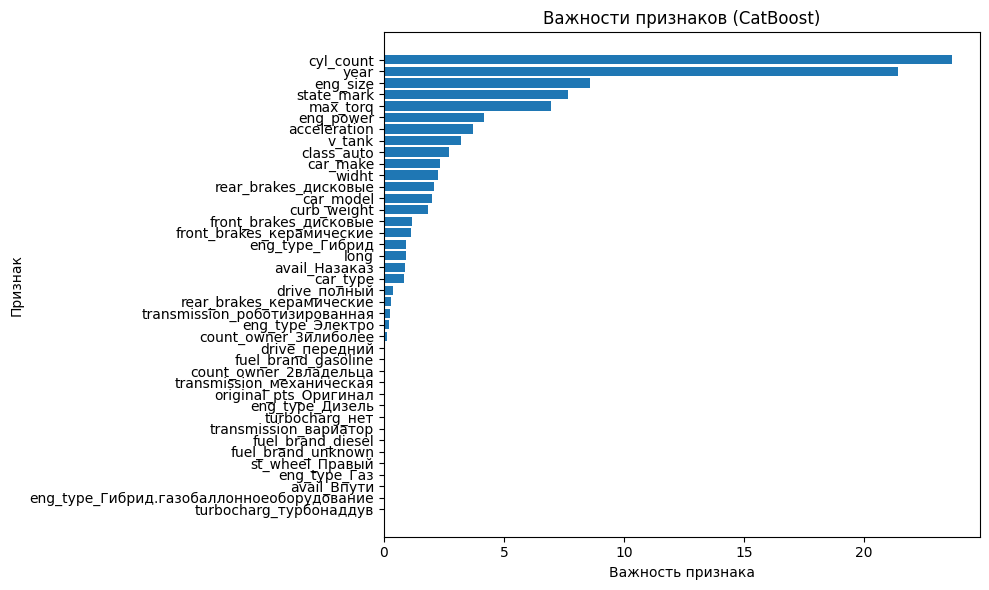

In [107]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_cat_grid['Признак'], feature_importances_df_cat_grid['Важность'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важности признаков (CatBoost)')
plt.tight_layout()
plt.show()

# 3. Анализ моделей

### **Линейная регрессия (c логарифмированием целевой переменной)**
- **R² (train):** 0.6099
- **MSE (train):** 16,426,983,642,624.46
- **R² (test):** 0.6869
- **MSE (test):** 11,719,949,823,157.80
- **Разница в R²:** -0.0770
- **Разница в MSE:** -4,707,033,819,466.66

---

### **LightGBM с GridSearchCV**
- **Лучшие параметры:**  
  `{colsample_bytree: 0.8, lambda_l1: 0.0, lambda_l2: 0.1, learning_rate: 0.1, max_depth: -1, min_child_samples: 5, ...}`
- **R² (train):** 0.9801
- **MSE (train):** 837,451,709,510.05
- **R² (test):** 0.9215
- **MSE (test):** 2,938,358,738,241.89
- **Разница в R²:** 0.0586
- **Разница в MSE:** -2,100,907,028,731.83

---

### **RandomForestRegressor с GridSearchCV**
- **Лучшие параметры:**  
  `{max_depth: 15, min_samples_leaf: 2, min_samples_split: 2, n_estimators: 100}`
- **R² (train):** 0.9165
- **MSE (train):** 3,518,253,953,936.99
- **R² (test):** 0.9280
- **MSE (test):** 2,696,361,247,355.22
- **Разница в R²:** -0.0115
- **Разница в MSE:** 821,892,706,581.78

---

### **CatBoost с GridSearchCV**
- **Лучшие параметры:**  
  `{iterations: 500, learning_rate: 0.1, depth: 6, l2_leaf_reg: 5, bagging_temperature: 0.1, border_count: 32}`
- **R² (train):** 0.9726
- **MSE (train):** 1,156,056,312,883.52
- **R² (test):** 0.9113
- **MSE (test):** 3,319,502,597,472.52
- **Разница в R²:** 0.0612
- **Разница в MSE:** -2,163,446,284,589.00

# 4. Выводы

1. **Выбор модели:**
   - **LightGBM** и **RandomForest** показали хорошие результаты с минимальной разницей между обучающими и тестовыми данными, что говорит об их надежности и способности хорошо работать на новых данных
   - **Линейная регрессия**, даже с логарифмированием целевой переменной, показала большую разницу между результатами на обучающей и тестовой выборках, что делает её менее устойчивой
   - **CatBoost** тоже показал хорошие результаты, но разница между обучающими и тестовыми данными у него больше, чем у **RandomForest**

2. **Эффективность:**
   - **LightGBM** и **CatBoost** работают быстрее, чем **RandomForest**, особенно при подборе параметров
3. **Итог** 
   - На основе производительности и баланса между результатами на обучающей и тестовой выборках, LightGBM с GridSearchCV является наиболее перспективной моделью для данного набора данных. Либо еще порабаотать с подкготвкой данных и подбором признаков и парамметров
